In [ ]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

from matplotlib import cm
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from statsmodels.distributions.empirical_distribution import ECDF

from ffc_utils import _fknn_forecast_dynamic_update

from functional_utils import _fDepth, _fQuantile

from scores_utils import *

plt.rcParams["legend.handlelength"] = 1
plt.rcParams["legend.handleheight"] = 1.125
plt.rcParams["font.family"]         = "Avenir"

path_to_fDepth     = '/home/gterren/dynamic_update/functional_forecast_dynamic_update/fDepth'
path_to_data       = '/home/gterren/dynamic_update/data'
path_to_validation = '/home/gterren/dynamic_update/validation'

# Loading color palette
palette_ = pd.read_csv(path_to_data + "/palette.csv")

# Loading Texas map
TX_ = gpd.read_file(path_to_data + "/maps/TX/State.shp")

# Historical random curves and day-ahead forecasts

In [2]:
T        = 288
resource = 'wind'

# Load 2017 data as training set
with open(path_to_data + f"/linear_preprocessed_{resource}_2017.pkl", 'rb') as f:
    _data = pkl.load(f)

assets_tr_ = _data["assets"]
x_tr_      = _data["locations"]
dates_tr_  = _data["dates"]
F_tr_      = _data["observations"]
E_tr_      = _data["forecasts"]
print(assets_tr_.shape, x_tr_.shape, dates_tr_.shape, F_tr_.shape, E_tr_.shape)

# Reshape to day x interval x asset format
F_tr_ = F_tr_.reshape(int(F_tr_.shape[0]/T), T, F_tr_.shape[1])
E_tr_ = E_tr_.reshape(int(E_tr_.shape[0]/T), T, E_tr_.shape[1])
T_tr_ = dates_tr_.reshape(int(dates_tr_.shape[0]/T), T)
print(F_tr_.shape, E_tr_.shape, T_tr_.shape)

# Load 2018 data as testing set
with open(path_to_data + f"/linear_preprocessed_{resource}_2018.pkl", 'rb') as f:
    _data = pkl.load(f)

assets_ts_ = _data["assets"]
x_ts_      = _data["locations"]
dates_ts_  = _data["dates"]
F_ts_      = _data["observations"]
E_ts_      = _data["forecasts"]
print(assets_ts_.shape, x_ts_.shape, dates_ts_.shape, F_ts_.shape, E_ts_.shape)

# Reshape to day x interval x asset format
F_ts_ = F_ts_.reshape(int(F_ts_.shape[0]/T), T, F_ts_.shape[1])
E_ts_ = E_ts_.reshape(int(E_ts_.shape[0]/T), T, E_ts_.shape[1])
T_ts_ = dates_ts_.reshape(int(dates_ts_.shape[0]/T), T)
print(F_ts_.shape, E_ts_.shape, T_ts_.shape)

dt_ = np.array([t * 5 for t in range(T)])
dx_ = pd.to_datetime(pd.DataFrame({"time": dt_}).time, unit = "m").dt.strftime("%H:%M").to_numpy()
print(dt_.shape, dx_.shape)

# Filter solar hours with loading solar set
idx_ = (np.sum(np.sum(F_tr_, axis = 0), axis = 1) 
        + np.sum(np.sum(F_ts_, axis = 0), axis = 1)
        + np.sum(np.sum(E_tr_, axis = 0), axis = 1)
        + np.sum(np.sum(E_ts_, axis = 0), axis = 1)) > 0.

F_tr_ = F_tr_[:, idx_, :]
E_tr_ = E_tr_[:, idx_, :]
T_tr_ = T_tr_[:, idx_]
print(F_tr_.shape, E_tr_.shape, T_tr_.shape)

F_ts_ = F_ts_[:, idx_, :]
E_ts_ = E_ts_[:, idx_, :]
T_ts_ = T_ts_[:, idx_]
print(F_ts_.shape, E_ts_.shape, T_ts_.shape)

# Short testing set with training set order
order      = {v: i for i, v in enumerate(assets_tr_)}
idx_       = np.argsort([order[x] for x in assets_ts_])
assets_ts_ = assets_ts_[idx_]
x_ts_      = x_ts_[idx_]
F_ts_      = F_ts_[:, :, idx_]
E_ts_      = E_ts_[:, :, idx_]
print(F_ts_.shape, E_ts_.shape, T_ts_.shape)

# From generation to capacity factor
p_tr_ = np.max(np.max(F_tr_, axis = 0), axis = 0)
p_ts_ = np.max(np.max(F_ts_, axis = 0), axis = 0)
print(p_tr_.shape, p_ts_.shape)

F_tr_ /= np.tile(p_tr_, (F_tr_.shape[0], F_tr_.shape[1], 1))
E_tr_ /= np.tile(p_tr_, (E_tr_.shape[0], E_tr_.shape[1], 1))
F_ts_ /= np.tile(p_ts_, (F_ts_.shape[0], F_ts_.shape[1], 1))
E_ts_ /= np.tile(p_ts_, (E_ts_.shape[0], E_ts_.shape[1], 1))
print(F_tr_.min(), F_tr_.max())
print(E_tr_.min(), E_tr_.max())
print(F_ts_.min(), F_ts_.max())
print(E_ts_.min(), E_ts_.max())

# No possible a capacity factor is larger than 1 or smaller than 0
F_tr_[F_tr_ > 1.] = 1.
F_tr_[F_tr_ < 0.] = 0.
F_ts_[F_ts_ > 1.] = 1.
F_ts_[F_ts_ < 0.] = 0.
E_tr_[E_tr_ > 1.] = 1.
E_tr_[E_tr_ < 0.] = 0.
E_ts_[E_ts_ > 1.] = 1.
E_ts_[E_ts_ < 0.] = 0.

print(assets_tr_.shape, T_tr_.shape)
# Format training set from day x interval x asset to [day * asset] x interval
T_tr_      = np.concatenate([T_tr_ for k in range(assets_tr_.shape[0])], axis = 0)
assets_tr_ = np.concatenate([np.tile(assets_tr_[k], (F_tr_.shape[0], 1)) for k in range(assets_tr_.shape[0])], axis = 0)
x_tr_      = np.concatenate([np.tile(x_tr_[k, :], (F_tr_.shape[0], 1)) for k in range(x_tr_.shape[0])], axis = 0)
F_tr_      = np.concatenate([F_tr_[..., k] for k in range(F_tr_.shape[2])], axis = 0)
E_tr_      = np.concatenate([E_tr_[..., k] for k in range(E_tr_.shape[2])], axis = 0)
print(x_tr_.shape, assets_tr_.shape, F_tr_.shape, E_tr_.shape, T_tr_.shape)
print(x_ts_.shape, assets_ts_.shape, F_ts_.shape, E_ts_.shape, T_ts_.shape)

t_tr_ = np.array([datetime.datetime.strptime(t_tr, "%Y-%m-%d %H:%M:%S").timetuple().tm_yday for t_tr in T_tr_[:, 0]]) - 1
t_ts_ = np.array([datetime.datetime.strptime(t_ts, "%Y-%m-%d %H:%M:%S").timetuple().tm_yday for t_ts in T_ts_[:, 0]]) - 1
print(t_tr_.shape, t_ts_.shape)

(187,) (187, 2) (104544,) (104544, 187) (104544, 187)
(363, 288, 187) (363, 288, 187) (363, 288)
(187,) (187, 2) (104832,) (104832, 187) (104832, 187)
(364, 288, 187) (364, 288, 187) (364, 288)
(288,) (288,)
(363, 288, 187) (363, 288, 187) (363, 288)
(364, 288, 187) (364, 288, 187) (364, 288)
(364, 288, 187) (364, 288, 187) (364, 288)
(187,) (187,)
0.0 1.0
-0.00014310971827851548 0.9999999888984703
0.0 1.0
-5.626724167500701e-18 1.113073847912657
(187,) (363, 288)
(67881, 2) (67881, 1) (67881, 288) (67881, 288) (67881, 288)
(187, 2) (187,) (364, 288, 187) (364, 288, 187) (364, 288)
(67881,) (364,)


# Functional kNNs dynamic update

In [ ]:
# # Calculate weighted (w_) distance between X_ and x_
# def _euclidian_dist(X_, x_, w_=[]):
#     if len(w_) == 0:
#         w_ = np.ones(x_.shape)
#     w_ = w_ / w_.sum()
#     d_ = np.zeros((X_.shape[0],))
#     for i in range(X_.shape[0]):
#         d_[i] = w_.T @ (X_[i, :] - x_) ** 2
#     return d_

# # Radial Basis function kernel based on distance (d_)
# def _kernel(d_, length_scale):
#     w_ = np.exp(-d_ / length_scale)
#     return w_  # /w_.sum()

# def _inv_dist(d_, length_scale):
#     w_ = 1.0 / (d_ + length_scale)
#     return w_  # /w_.sum()

# # Define exponential growth function
# def _exponential_growth(t, dacay_rate, innit = 0):
#     tau_ = np.linspace(t - 1, 0, t)
#     return np.exp(-dacay_rate*tau_)

# # Define exponential dacay function
# def _exponential_decay(S, dacay_rate):
#     s_ = np.linspace(0, S - 1, S)
#     return np.exp(-dacay_rate*s_)

# def _logistic(x_, k=1.0):
#     return 1.0 / (1.0 + np.exp(-k * x_))
    
# def _haversine_dist(x_1_, x_2_):
#     """
#     Calculate the distance between two points on Earth using the Haversine formula.

#     Args:
#         x_1_ (float): Longitude and latitude of the first point in degrees.
#         x_2_ (float): Longitude and latitude of the second point in degrees.

#     Returns:
#         float: Distance between the two points in kilometers.
#     """
#     R = 6371  # Radius of Earth in kilometers

#     dlat_ = np.deg2rad(x_2_[:, 1]) - np.deg2rad(x_1_[1])
#     dlon_ = np.deg2rad(x_2_[:, 0]) - np.deg2rad(x_1_[0])

#     theta = (np.sin(dlat_ / 2) ** 2
#              + np.cos(np.deg2rad(x_1_[1]))
#              * np.cos(np.deg2rad(x_2_[:, 1]))
#              * np.sin(dlon_ / 2) ** 2)

#     return 2.0 * R * np.arcsin(np.sqrt(theta))

# # # Fuse day-ahead forecast with real-time forecast
# # def _update_forecast(F_ac_, f_hat_, fc_, update_rate):

# #     w_update_ = 1. - _exponential_decay_plus(F_ac_.shape[1] + 1, update_rate)[1:]
# #     #w_update_ = eta_/eta_.max()
# #     f_update_ = f_hat_*(1. - w_update_) + fc_*w_update_

# #     plt.figure(figsize = (10, 2))
# #     plt.title('Trust Rate')
# #     plt.plot(w_update_)
# #     plt.show()

# #     return f_update_


# # Define a function to calculate quantiles
# def _KDE_quantile(_KDE, q_, x_min=0.0, x_max=1.0, n_samples=1000):
#     """
#     Calculates the quantile for a given probability using KDE.

#     Parameters:
#     _KDE: Kernel density estimate object (e.g., from scipy.stats.gaussian_kde).
#     q:    Probability value (between 0 and 1) for which to calculate the quantile.

#     Returns:
#     The quantile value.
#     """

#     # Calculate CDF
#     x_ = np.linspace(x_min, x_max, n_samples)
#     # z_ = np.exp(_KDE.score_samples(x_[:, np.newaxis]))
#     w_ = np.cumsum(np.exp(_KDE.score_samples(x_[:, np.newaxis])))
#     # Normalize CDF
#     w_ /= w_[-1]

#     return np.interp(np.array(q_), w_, x_), np.interp(1.0 - np.array(q_), w_, x_)

# # Silverman's Rule
# def _silverman_rule(x_):
#     IQR = np.percentile(x_, 75) - np.percentile(x_, 25)
#     return 0.9 * min(np.std(x_), IQR / 1.34) * x_.shape[0] ** (-1 / 5)

# # Periodic distance to rank samples by day of the year
# def _periodic_dist(x_1_, x_2_, day_to_degree=360/365, degree_to_rad=np.pi / 180):
#     return np.sin(0.5 * (day_to_degree * (x_2_ - x_1_) * degree_to_rad) ) ** 2

# # Filtering scenarios when they are above the upper threshold or below the lower threshold
# def _scenario_filtering(W_, d_h_, d_p_, xi, gamma, kappa_min, kappa_max):

#     status = 0
#     sigma  = 0

#     # Similarity ranking
#     idx_rank_ = np.argmin(W_, axis=0)

#     # Similarity filter
#     w_ = np.min(W_, axis=0)
#     idx_bool_ = w_ >= xi
#     print(kappa_min, idx_bool_.sum(), kappa_max)

#     # Index from selected scenarios
#     idx_1_ = np.arange(w_.shape[0])[idx_bool_]
#     # Filter by temporal distance
#     if idx_bool_.sum() > kappa_max:
#         print("(1) Filtering by date: ")
#         idx_bool_p_ = idx_bool_ & (d_p_ <= gamma)
#         print(idx_bool_p_.sum())

#         if idx_bool_p_.sum() > kappa_min:
#             status    = 1
#             idx_bool_ = idx_bool_p_.copy()
#         else:
#             print(" Bypass filtering by date: ")
#             gamma = 0
#             print(idx_bool_.sum())

#     idx_2_ = np.arange(w_.shape[0])[idx_bool_]

#     # Filter by spatial distance
#     if idx_bool_.sum() > kappa_max:
#         print("(2) Filtering by distance: ")
#         status    = 2
#         sigma     = np.sort(d_h_[idx_bool_])[kappa_max]
#         idx_bool_ = idx_bool_ & (d_h_ <= sigma)
#         print(idx_bool_.sum())

#     if idx_bool_.sum() < kappa_min:
#         print("Increasing similarity threshold: ")
#         status    = 2
#         gamma     = 0
#         xi        = np.sort(w_)[::-1][kappa_min]
#         idx_bool_ = w_ >= xi
#         print(idx_bool_.sum())

#     idx_3_ = np.arange(w_.shape[0])[idx_bool_]

#     return w_, idx_rank_, idx_bool_, idx_1_, idx_2_, idx_3_, xi, gamma, sigma, status

In [ ]:
# # d = 11 high day-ahead error
# # d = 5 low day-ahead error
# # When we calculate the maximum in the similarity, it should be the minimum instead.
# # sparsest: (array([ 33,  84,  89,  92, 148, 176, 249, 256]), array([7, 6, 8, 6, 8, 8, 8, 6]))
# # densest 15683.0: (array([195]), array([4]))
# # densest: 99
# # sprasest: 4

# a = 0
# d = 0
# t = 12 * 12
# file_name = f"{a}-{d}-{t}"
# print(file_name)

# # Weighting functions parameters
# forget_rate_f = .1
# forget_rate_e = .1
# lookup_rate   = .1
# trust_rate    = .1

# # Distance parameters
# length_scale_f = .1
# length_scale_e = .1
# # Scenario selection parameters
# gamma     = _periodic_dist(t_tr_[d], 90)
# xi        = 0.99
# kappa_min = 100
# kappa_max = 350

# f_     = F_ts_[d, :t, a]
# f_hat_ = F_ts_[d, t:, a]
# e_     = E_ts_[d, :, a]

# # Get constants
# T    = E_ts_.shape[1]
# tau_ = dt_[:t]
# s_   = dt_[t:]

# # phi: importance weights based on past time distance
# phi_ = _exponential_growth(t, forget_rate_f)
# # psi: importance weights based on past and future time distance
# psi_1_ = _exponential_growth(t, forget_rate_e)
# psi_2_ = _exponential_decay(T - t, lookup_rate)
# psi_   = np.concatenate([psi_1_, psi_2_], axis = 0)
    
# # d: Euclidean distance between samples weighted by importance weights
# d_f_ = _euclidian_dist(F_tr_[:, :t], f_, w_ = phi_)
# d_e_ = _euclidian_dist(E_tr_, e_, w_ = psi_)
# d_h_ = _haversine_dist(x_ts_[a, :], x_tr_)
# d_p_ = _periodic_dist(t_tr_[d], t_tr_)
# print(x_tr_.shape, x_ts_.shape, d_h_.shape)
# print(t_tr_.shape, t_ts_.shape, d_p_.shape)

# # w: normalized weights distance across observations based on the exponential link function
# w_f_ = _kernel(d_f_, length_scale_f)
# w_e_ = _kernel(d_e_, length_scale_e)
# W_   = np.stack([w_f_, w_e_])

# (w_, 
#  idx_rank_, 
#  idx_bool_, 
#  idx_1_, 
#  idx_2_, 
#  idx_3_, 
#  xi, 
#  gamma, 
#  sigma, 
#  status) = _scenario_filtering(W_, d_h_, d_p_, xi, gamma, kappa_min, kappa_max)

# # eta: importance weights based on future time distance
# # rmse       = np.sqrt(np.mean((e_[:t] - f_) ** 2))
# # wrmse      = np.sqrt(np.sum(psi_1_ * (e_[:t] - f_) ** 2) / psi_1_.sum())
# # nu         = t*5 + (24*12*5 - t*5)*rmse
# # trust_rate = np.exp(1. - rmse)/(1 + 200*rmse)
# # print(trust_rate)
# # print(rmse, wrmse, nu, trust_rate, t*5, ((24*12*5 - t*5)*rmse))

# nu = t*5 + 300

# eta_ = _logistic(s_ - nu, k = trust_rate)

# # Fuse scenarios with day-ahead forecasts
# M_ = np.zeros((idx_3_.shape[0], eta_.shape[0]))
# for i, j in zip(idx_3_, range(idx_3_.shape[0])):
#     M_[j, :] = F_tr_[i, t:] * (1.0 - eta_) + E_tr_[i, t:] * eta_
# print(M_.shape)

In [5]:
# Day-Ahead + Observations
forget_rate_f  = 0.125
forget_rate_e  = 0.25
lookup_rate    = 256
length_scale_f = 0.025  
length_scale_e = 0.001
trust_rate     = 0.3
nu             = 10
xi             = 0.95
gamma          = 60
kappa_min      = 50
kappa_max      = 1250

asset = 0
day   = 0
time  = 144

file_name = f'{asset}-{day}-{time}'
#print(i_job, file_name)

f_     = F_ts_[day, :time, asset]
e_     = E_ts_[day, :, asset]
x_     = x_ts_[asset, :]
t      = t_ts_[day]
f_hat_ = F_ts_[day, time:, asset]

# Get time constants
tau_ = dt_[:time]
s_   = dt_[time:]

_meta, M_ = _fknn_forecast_dynamic_update(F_tr_, E_tr_, x_tr_, t_tr_, dt_, f_, e_, x_, t,
                                          forget_rate_f  = forget_rate_f,
                                          forget_rate_e  = forget_rate_e,
                                          length_scale_f = length_scale_f,
                                          length_scale_e = length_scale_e,
                                          lookup_rate    = lookup_rate,
                                          trust_rate     = trust_rate,
                                          nu             = nu,
                                          gamma          = gamma,
                                          xi             = xi,
                                          kappa_min      = kappa_min,
                                          kappa_max      = kappa_max)

findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.


findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not

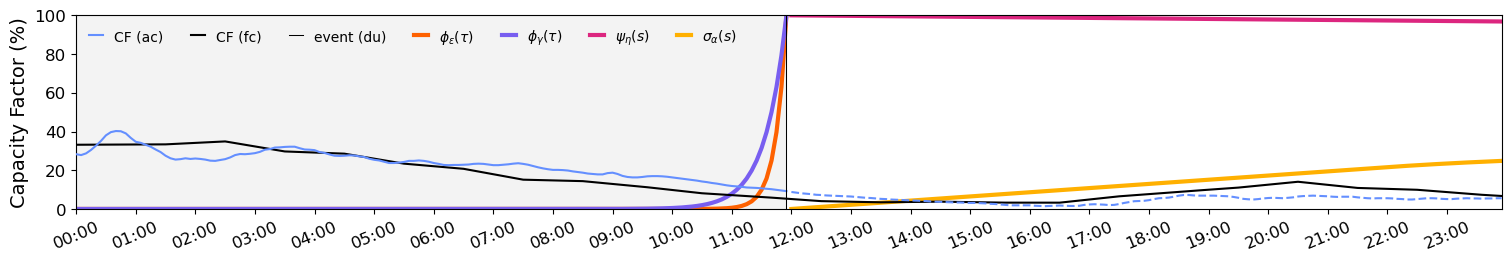

In [10]:
def _plot_forecast_parameters(_ax, f_, e_, f_hat_, phi_, psi_, eta_, dx_, dt_, t):

    tau_ = dt_[:t]
    s_ = dt_[t:]

    _ax.plot(tau_, 100.0 * f_, c=palette_.loc[0, "ibm"], label="CF (ac)", lw=1.5, zorder=5)

    _ax.plot(s_, 100.0 * f_hat_, c=palette_.loc[0, "ibm"], lw=1.5, ls="--", zorder=5)

    _ax.plot(dt_, 100.0 * e_, lw=1.5, label="CF (fc)", c="k", zorder=4)

    _ax.fill_between(
        tau_,
        100.0 * np.ones(tau_.shape),
        100.0 * np.zeros(tau_.shape),
        color="lightgray",
        alpha=0.25,
        zorder=1,
    )

    _ax.axvline(dt_[t - 1], color="k", lw=0.75, label="event (du)", zorder=6)

    _ax.plot(
        tau_,
        100.0 * phi_,
        c=palette_.loc[3, "ibm"],
        lw=3,
        label=r"$\phi_{\varepsilon} (\tau)$",
        zorder=2,
    )

    _ax.plot(
        tau_,
        100.0 * psi_[:t],
        c=palette_.loc[1, "ibm"],
        lw=3,
        label=r"$\phi_{\gamma} (\tau)$",
        zorder=2,
    )

    _ax.plot(
        s_,
        100.0 * psi_[t:],
        c=palette_.loc[2, "ibm"],
        lw=3,
        label=r"$\psi_{\eta} (s)$",
        zorder=2,
    )

    _ax.plot(
        s_,
        100.0 * eta_,
        c=palette_.loc[4, "ibm"],
        lw=3,
        label=r"$\sigma_{\alpha} (s) $",
        zorder=2,
    )

    _ax.set_xticks(dt_[::12], dx_[::12], rotation=22.5)
    _ax.set_ylabel("Capacity Factor (%)", size=14)
    _ax.tick_params(axis="both", labelsize=12)
    _ax.set_ylim(0.0, 100.0)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.legend(frameon=False, ncol=10, loc="upper left")

fig, _ax = plt.subplots(1, 1, figsize=(15, 2.5), layout="constrained")

_plot_forecast_parameters(_ax, f_, e_, f_hat_, _meta['phi'], _meta['psi'], _meta['eta'], dx_, dt_, time)

plt.show()

# fig, _ax = plt.subplot_mosaic([[".", ".", "c", ".", ".", "."],
#                                ["a", "a", "b", "d", "e", "e"],
#                                ["a", "a", "b", "d", "e", "e"]],
#                                figsize     = (15, 5.75),
#                                layout      = "constrained",
#                                gridspec_kw = dict(width_ratios  = (2, 2, 4, 1, 2, 2), 
#                                                   height_ratios = (1, 2, 2)))

# _plot_fneighborhood(_ax, d_f_, d_e_, w_f_, w_e_, w_, idx_bool_, idx_1_, idx_3_, xi)

# plt.show()

# Visualization Utils

NameError: name 'phi_' is not defined

findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not

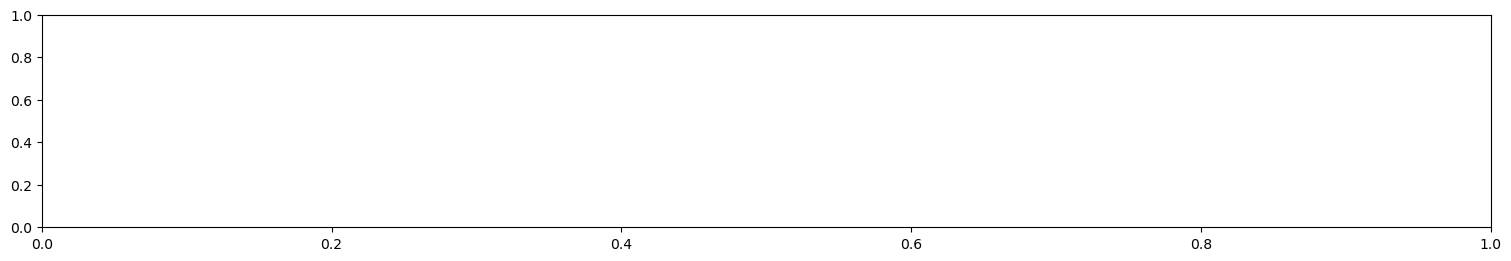

In [ ]:



fig, _ax = plt.subplots(1, 1, figsize=(15, 2.5), layout="constrained")

_plot_forecast_parameters(_ax, f_, e_, f_hat_, phi_, psi_, eta_, dx_, dt_, t)

plt.savefig(path_to_images + r"/parameters.png", bbox_inches="tight", dpi=300)

plt.show()

NameError: name 'x_tr_' is not defined

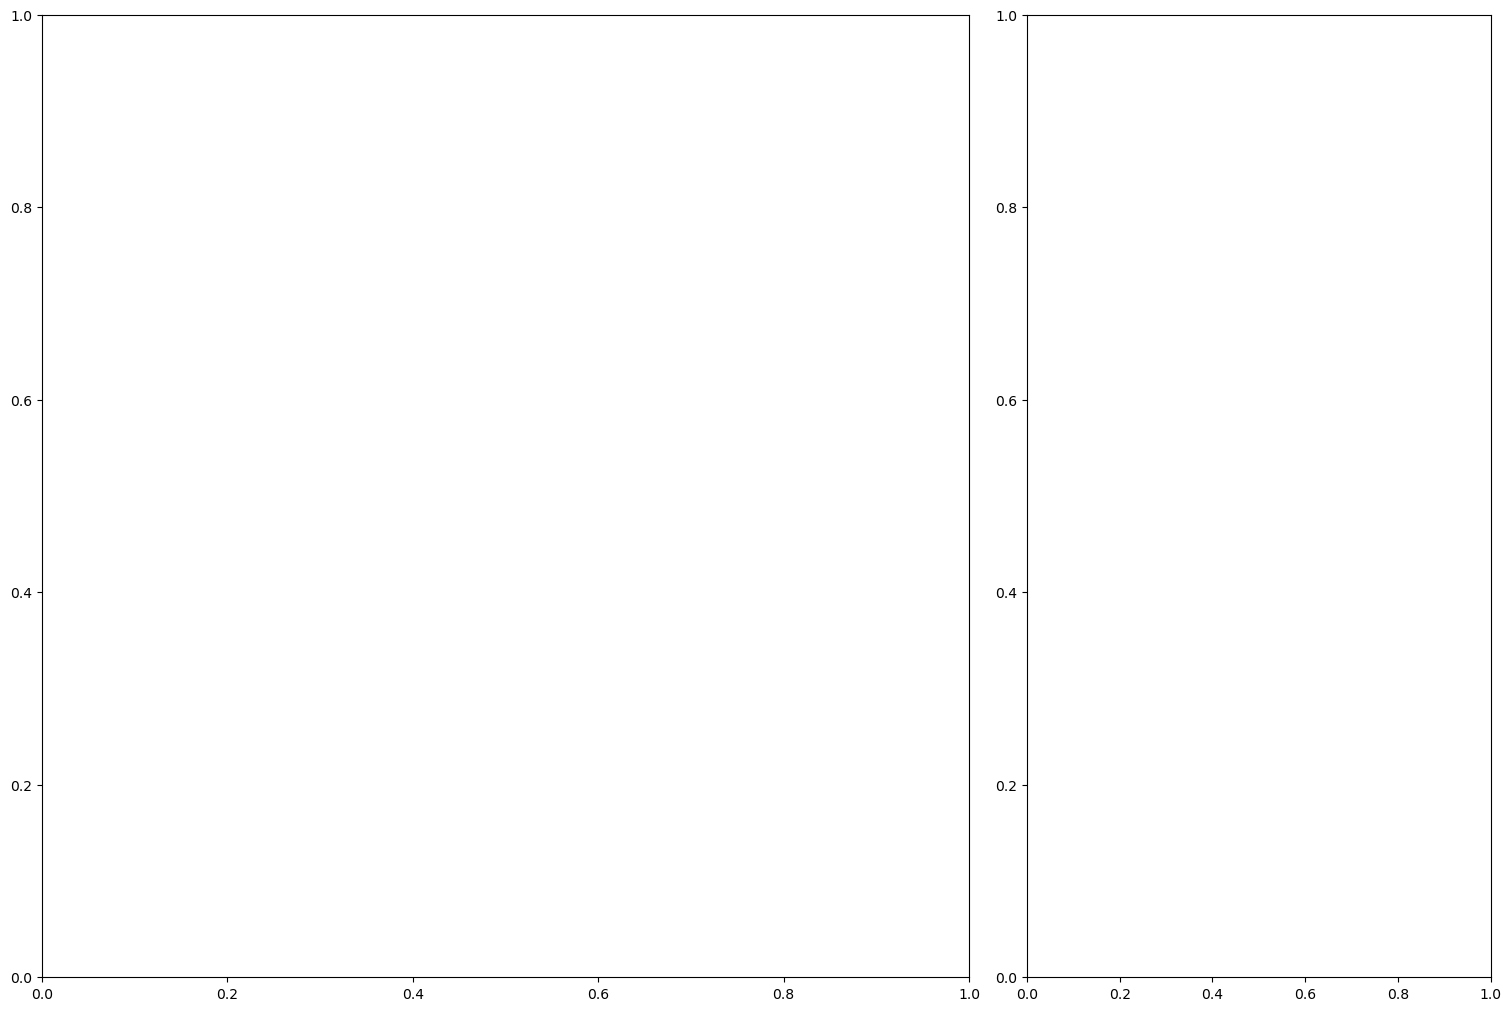

In [4]:
def _plot_frequency_map(_ax, x_tr_, x_ts_, x_, idx_bool_, idx_1_, sigma):

    print(sigma)

    x_tr_p_, z_tr_p_ = np.unique(x_tr_[idx_1_, :], return_counts=True, axis=0)
    #x_tr_pp_, z_tr_pp_ = np.unique(x_tr_[idx_2_, :], return_counts=True, axis=0)

    _cmap = sns.color_palette("rocket_r", as_cmap=True)
    _norm = plt.Normalize(0.0, z_tr_p_.max())

    TX_.plot(ax=_ax, 
             facecolor="lightgray", 
             edgecolor="white", 
             zorder=0)

    _ax.scatter(x_[0], x_[1],
                c="lime",
                lw=0.5,
                ec="k",
                s=200.0,
                zorder=1,
                marker="^",
                label="Asset (du)")

    if sigma > 0:
        _ax.scatter(x_[0], x_[1],
                    c="none",
                    lw=0.5,
                    ec="k",
                    ls = '--',
                    s=sigma**2,
                    zorder=1,
                    marker="o")

    _ax.plot(x_[0], x_[1],
             c="k",
             marker="None",
             ls="--",
             label="Distance threshold")
    
    _ax.plot(x_ts_[:, 0], x_ts_[:, 1],
             c="gray",
             alpha=0.75,
             ms=6,
             marker="o",
             mec="w",
             ls="none",
             mew=1.0,
             zorder=2,
             label="Assets wo/ neighbors")

    _ax.plot(x_[0], x_[1],
             c=_cmap(_norm(z_tr_p_.max() / 2.0)),
             alpha=0.75,
             ms=6,
             ls="none",
             marker="o",
             mec="w",
             mew=1.0,
             zorder=0,
             label="Assets w/ neighbors")

    _ax.plot(x_[0], x_[1],
             c=_cmap(_norm(z_tr_p_.max() / 4.0)),
             alpha=0.75,
             ms=6,
             ls="none",
             marker="o",
             mec="k",
             mew=0.5,
             zorder=0,
             label="Assets w/ neighbors after filtering-out")

    for i in np.arange(x_tr_p_.shape[0], dtype=int)[np.argsort(z_tr_p_)]:
        _ax.plot(x_tr_p_[i, 0], x_tr_p_[i, 1],
                 c=_cmap(_norm(z_tr_p_[i])),
                 alpha=0.75,
                 ms=6,
                 ls="none",
                 marker="o",
                 mec="w",
                 mew=1.0,
                 zorder=4)

    x_tr_ppp_ = x_tr_[idx_bool_, :]

    for i in range(x_tr_ppp_.shape[0]):
        _ax.plot(x_tr_ppp_[i, 0], x_tr_ppp_[i, 1],
                 #c=_cmap(_norm(z_tr_p_[i])),
                 alpha=0.75,
                 ms=6,
                 ls="none",
                 marker="o",
                 c = 'none', 
                 mec="k",
                 mew=1.0,
                 zorder=5)

    cbar = fig.colorbar(cm.ScalarMappable(cmap=_cmap),
                        cax=_ax.inset_axes([-97.75, 35.5, 2.0, 0.25], 
                                           transform=_ax.transData),
                        orientation="horizontal",
                        extend="both")

    cbar.set_ticks([0, 1], labels=["low", "high"], fontsize=12)
    cbar.ax.tick_params(length=0)
    cbar.ax.set_title("Frequency", rotation=0, fontsize=12)

    _ax.legend(frameon=False,
               # loc     = 'upper left',
               bbox_to_anchor=(0.475, 0.25),
               ncol=1,
               fontsize=12)

    # Add compass (North arrow)
    x, y, arrow_length = 0.19, 0.94, 0.0625  # relative axes coords
    _ax.annotate("N",
                 xy=(x, y),
                 xytext=(x, y - arrow_length),
                 arrowprops=dict(facecolor="k", 
                                 arrowstyle="wedge,tail_width=1,shrink_factor=.5"),
                 ha="center",
                 va="center",
                 fontsize=14,
                 xycoords=_ax.transAxes)

    scalebar = ScaleBar(dx=100,  # scaling factor
                        units="km",
                        dimension="si-length",  # could also be 'imperial-length'
                        location='upper left',
                        length_fraction=0.075,  # fraction of the axis for bar length
                        color="black",
                        box_color="None",
                        box_alpha=1.0,
                        border_pad=9,
                        font_properties={"size": 14})

    _ax.add_artist(scalebar)

    _ax.set_axis_off()


def _selected_scenarios_heatmap(_ax, T_tr_, T_ts_, x_ts_, idx_1_):

    N     = 12
    delta = 15

    d_      = _haversine_dist(x_ts_[a, :], x_ts_)
    d_sort_ = np.sort(d_)[:-7]

    tops_      = [int((i + 1) * delta) for i in range(N)]
    intervals_ = [d_sort_[i - 1] for i in tops_]

    m_a   = datetime.datetime.strptime(T_ts_[d], "%Y-%m-%d").timetuple().tm_mon - 1
    m_tr_ = np.stack([datetime.datetime.strptime(T_tr_[i], "%Y-%m-%d").timetuple().tm_mon - 1
                      for i in range(T_tr_.shape[0])])

    K        = 0
    heatmap_ = np.zeros((N + 1, m_tr_.max() + 1))
    for d_h, m in zip(d_h_[idx_1_], m_tr_[idx_1_]):
        heatmap_[np.searchsorted(intervals_, d_h), m] += 1
        K += 1

    _cmap = sns.color_palette("rocket_r", as_cmap=True)

    month_ = ["Jan",
              "Feb",
              "Mar",
              "Apr",
              "May",
              "Jun",
              "Jul",
              "Aug",
              "Sep",
              "Oct",
              "Nov",
              "Dec"]

    print(K, month_[m_a])

    _ax.matshow(heatmap_[:-1, :], 
                cmap = _cmap, 
                vmin=0.0, 
                extent=[0, 12, N, 0])

    _ax.set_xticks(range(len(month_)), [] * len(month_))
    _ax.set_yticks(range(len(tops_)), [] * len(tops_))

    _ax.set_ylabel("Top Neighboring Assets", size=16)
    _ax.set_xlabel("Month", size=16)
    _ax.xaxis.set_label_position("top")

    _ax.set_xticks(np.arange(len(month_), dtype=int) + 0.5, month_,
                   rotation=45,
                   minor=True,
                   size=14)

    _ax.set_yticks(np.arange(len(tops_), dtype=int) + 0.5, tops_,
                   minor=True,
                   size=14)

    _ax.tick_params(which="major", bottom=False, left=False, top=False)
    _ax.tick_params(which="minor", bottom=False)
    _ax.grid(which="major", 
             color="k", 
             linestyle="-", 
             linewidth=1.5)

#     cbar = fig.colorbar(cm.ScalarMappable(cmap = _cmap),
#                         cax = ax.inset_axes([3.5, 19, 5., .5], transform = ax.transData),
#                         orientation = 'horizontal',
#                         extend      = 'both')

#     cbar.set_ticks([0, 1], labels = ['low', 'high'], size = 12)
#     cbar.ax.tick_params(length = 0)
#     cbar.ax.set_title('Frequency', rotation = 0, size = 14)

fig, _ax = plt.subplot_mosaic(
    [["a", "b"]],
    figsize     = (15, 10),
    layout      = "constrained",
    gridspec_kw = dict(width_ratios = (2, 1)))

_plot_frequency_map(_ax["a"], x_tr_, x_ts_, x_ts_[a, :], idx_bool_, idx_1_, sigma)
_selected_scenarios_heatmap(_ax["b"], T_tr_, T_ts_, x_ts_, idx_1_)
# plt.savefig(path_to_images + r"/frequency_mosaic.png", bbox_inches="tight", dpi=600)
# plt.savefig(path_to_images + r"/frequency_mosaic.pdf", bbox_inches="tight", dpi=600)

plt.show()

In [ ]:
def _plot_scenario_filtering(_ax, d_h_, d_p_, idx_1_, idx_2_, sigma, 
                             lower, upper):

    _ax.scatter(d_p_[idx_1_], d_h_[idx_1_],
                s=75,
                c="darkgray",
                lw=0.5,
                edgecolor="w",
                clip_on=False,
                zorder=4,
                label="Neineighbors")
    
    _ax.scatter(d_p_[idx_2_], d_h_[idx_2_],
                s=75,
                c=palette_.loc[3, "ibm"],
                lw=0.5,
                edgecolor="k",
                clip_on=False,
                zorder=5,
                label="Filtered-out")

    if (lower != 0) & (upper != 0):   
        _ax.axvline(upper, 
                    c="k", 
                    ls = '--', 
                    lw=1.5, 
                    zorder=10)
                    
        _ax.axvline(lower, 
                    c="k", 
                    ls = '--', 
                    lw=1.5, 
                    zorder=10, 
                    label="Thresholds")
            
    if sigma != 0:
        _ax.axhline(sigma, 
                    c="k", 
                    ls = '--', 
                    lw=1.5, 
                    zorder=10)

    #_ax.set_ylabel(r"$|| \mathbf{x}_\star - \mathbf{x}_n ||_\mathrm{H}$", size=14)
    #_ax.set_xlabel(r"$|| d_\star - d_n ||_\mathrm{p}$", size=16)
    _ax.set_xlabel(r"Year Day", size=16)
    _ax.set_ylabel(r"Distance (km)", size=16)

    _ax.tick_params(axis="both", labelsize=14)
    #sns.despine(ax=_ax, offset = 5, trim = True)


def _plot_dates_histogram(_ax, t_tr_, idx_1_, idx_2_, lower, upper):

    _ax.hist(t_tr_[idx_1_], 
             bins=50, 
             range=(1, 365), 
             color="darkgray", 
             edgecolor="w", 
             lw=0.5)

    _ax.hist(t_tr_[idx_2_],
             bins=50,
             range=(1, 365),
             alpha=0.5,
             color=palette_.loc[3, "ibm"],
             edgecolor="k",
             lw=0.5)

    _ax.axvline(lower, 
                c="k", 
                ls="--", 
                lw=1.5, 
                zorder=2, 
                label="d: day")
    
    _ax.axvline(upper, 
                c="k", 
                ls="--", 
                lw=1.5, 
                zorder=2, 
                label="d: day")
    
    #_ax.set_xlabel(r"Year Day", size=16)
    _ax.set_ylabel(r"Scenarios", size=16)
    #_ax.set_xlim(1, 365)
    _ax.tick_params(axis="both", labelsize=14)
    #_ax.legend(frameon=False, ncol=1, fontsize = 12)
    _ax.set_xticks([], [])

def _plot_distance_histogram(_ax, d_h_, idx_1_, idx_2_, d_max = 1200):
    print(d_h_.max())

    d_max = d_h_.max()
    
    _ax.hist(d_h_[idx_1_], 
             bins=50, 
             range=(0, d_max), 
             color="darkgray", 
             edgecolor="w", 
             lw=0.5, 
             orientation="horizontal")
    
    _ax.hist(d_h_[idx_2_],
             bins=50,
             range=(0, d_max),    
             alpha=0.5,
             color=palette_.loc[3, "ibm"],
             edgecolor="k",
             lw=0.5, 
             orientation="horizontal")
    
    _ax.axhline(d_h_[idx_2_].max(), 
                c="k", 
                ls="--", 
                lw=1.5, 
                zorder=2, 
                label="r: max distance")
    
    #_ax.set_xlabel(r"Distance (km)", size=16)
    _ax.set_xlabel(r"Scenarios", size=16)
    #_ax.set_xlim(0, d_max)
    _ax.tick_params(axis="both", labelsize=14, rotation = 270)
    _ax.set_yticks([], [])

    #_ax.legend(frameon=False, ncol=1, fontsize = 12)

fig, _ax = plt.subplot_mosaic(
    [["a", "."], 
     ["b", "c"]],
    figsize     = (7.5, 7.5),
    layout      = "constrained",
    gridspec_kw = dict(width_ratios = (1, .25), 
                       height_ratios = (.25, 1)))

upper = d + gamma_p + 1
lower = d - gamma_p + 1

if upper > 365: upper = upper - 365
if lower < 1:   lower = lower + 365

_plot_dates_histogram(_ax["a"], t_tr_, idx_1_, idx_2_, lower, upper)
_plot_scenario_filtering(_ax["b"], d_h_, t_tr_, idx_1_, idx_2_, sigma, lower, upper)
_plot_distance_histogram(_ax["c"], d_h_, idx_1_, idx_2_, d_max = 1200)

_ax["b"].legend(frameon=False, ncol=3, loc = (0., 1.), fontsize = 12)


# plt.savefig(path_to_images + r"/frequency_mosaic.png", bbox_inches="tight", dpi=600)
# plt.savefig(path_to_images + r"/frequency_mosaic.pdf", bbox_inches="tight", dpi=600)

plt.show()

NameError: name 'd_f_' is not defined

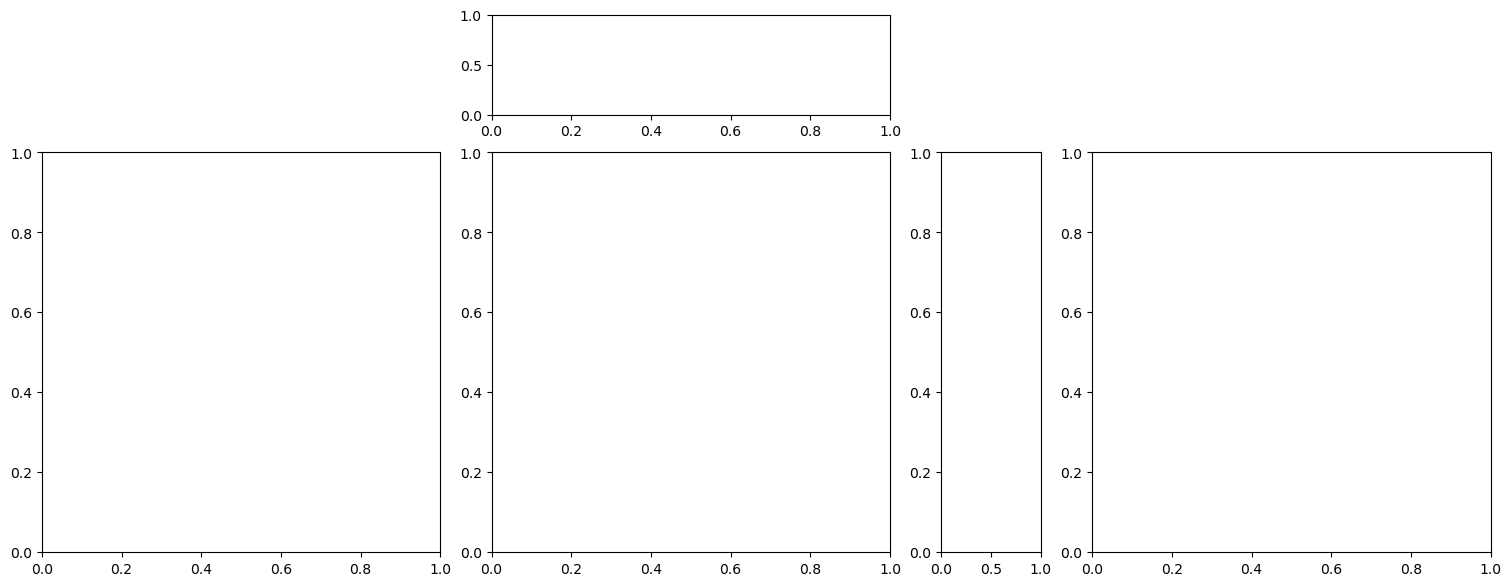

In [5]:
def _plot_fneighborhood(_ax, d_f_, d_e_, w_f_, w_e_, w_, 
                        idx_0_, idx_1_, idx_2_, xi):

    _ax["a"].plot(d_f_[np.argsort(d_f_)], w_f_[np.argsort(d_f_)],
                  c=palette_.loc[0, "ibm"],
                  lw=2.5,
                  label="f")

    _ax["a"].plot(d_e_[np.argsort(d_e_)], w_e_[np.argsort(d_e_)],
                  c=palette_.loc[3, "ibm"],
                  lw=2.5,
                  label="e")

    _ax["a"].axhline(xi, ls="--", color="k", lw=1.0, label=r"$\xi$", zorder=10)
    _ax["a"].set_ylabel(r"$\varphi_{\lambda} (r)$", size=14)
    _ax["a"].set_xlabel(r"$r$", size=14)
    _ax["a"].tick_params(axis="both", labelsize=12)
    _ax["a"].legend(frameon=False, fontsize=12)

    _ax["e"].scatter(w_f_, w_e_, 
                     c="gray", 
                     s=35, 
                     alpha=1.0, 
                     lw=0.25, 
                     ec="k", 
                     label="Scen.")

    _ax["e"].scatter(w_f_[idx_1_], w_e_[idx_1_],
                     c=palette_.loc[0, "ibm"],
                     s=35,
                     alpha=1.0,
                     lw=0.25,
                     ec="k",
                     label="Neighbors")

    c_ = [palette_.loc[2, "ibm"], palette_.loc[4, "ibm"]]
    # for i, j in zip(idx_2_, idx_0_[idx_2_]):
    _ax["e"].scatter(w_f_[idx_2_], w_e_[idx_2_],
                     c=palette_.loc[3, "ibm"],
                     s=35,
                     lw=0.25,
                     ec="k",
                     alpha=1.0,
                     label="Filtered-out")

    _ax["e"].axline((1, 1), slope=1, lw=1, c="k")
    _ax["e"].set_ylabel(r"$\varphi_{\lambda_e} (r_{e})$", size=14)
    _ax["e"].set_xlabel(r"$\varphi_{\lambda_f} (r_{f})$", size=14)
    _ax["e"].tick_params(axis="both", labelsize=12)
    _ax["e"].set_xlim(w_f_[idx_2_].min() * 0.9985, w_f_[idx_2_].max() * 1.0015)
    _ax["e"].set_ylim(w_e_[idx_2_].min() * 0.9985, w_e_[idx_2_].max() * 1.0015)
    _ax["e"].axhline(xi, ls="--", color="k", lw=1.0, zorder=10)
    _ax["e"].axvline(xi, ls="--", color="k", lw=1.0, zorder=10)
    _ax["e"].legend(frameon=False, fontsize=12, ncol=3)

    _ax["c"].tick_params(axis="x", labelbottom=False)
    _ax["d"].tick_params(axis="y", labelleft=False)

    _ax["b"].scatter(w_f_, w_e_, color="gray", s=0.25, zorder=1)

    _ax["b"].scatter(w_f_[idx_1_], w_e_[idx_1_], 
                     c=palette_.loc[0, "ibm"], 
                     s=0.25, 
                     zorder=2)

    _ax["b"].axhline(xi, ls="--", color="k", lw=1.0, label=r"$\xi$", zorder=10)

    _ax["b"].axvline(xi, ls="--", color="k", lw=1.0, label=r"$\xi$", zorder=10)

    _ax["b"].set_ylabel(r"$\varphi_{\lambda_e} (r_{e})$", size=14)
    _ax["b"].set_xlabel(r"$\varphi_{\lambda_f} (r_{f})$", size=14)
    _ax["b"].tick_params(axis="both", labelsize=12)

    _ax["c"].hist(w_f_, bins=50, color="gray", density=True)

    _ax["c"].tick_params(axis="both", labelsize=12)

    _ax["d"].hist(w_e_, bins=50, color="gray", density=True, orientation="horizontal")

    _ax["d"].tick_params(axis="both", labelsize=12)

fig, _ax = plt.subplot_mosaic([[".", ".", "c", ".", ".", "."],
                              ["a", "a", "b", "d", "e", "e"],
                              ["a", "a", "b", "d", "e", "e"]],
                              figsize     = (15, 5.75),
                              layout      = "constrained",
                              gridspec_kw = dict(width_ratios  = (2, 2, 4, 1, 2, 2), 
                                                 height_ratios = (1, 2, 2)))

_plot_fneighborhood(_ax, d_f_, d_e_, w_f_, w_e_, w_, idx_bool_, idx_1_, idx_2_, xi)

# plt.savefig(path_to_images + r"/fneighbor.png", bbox_inches="tight", dpi=300)
# plt.savefig(path_to_images + r"/fneighbor.pdf", bbox_inches="tight", dpi=300)

plt.show()

ValueError: zero-size array to reduction operation minimum which has no identity

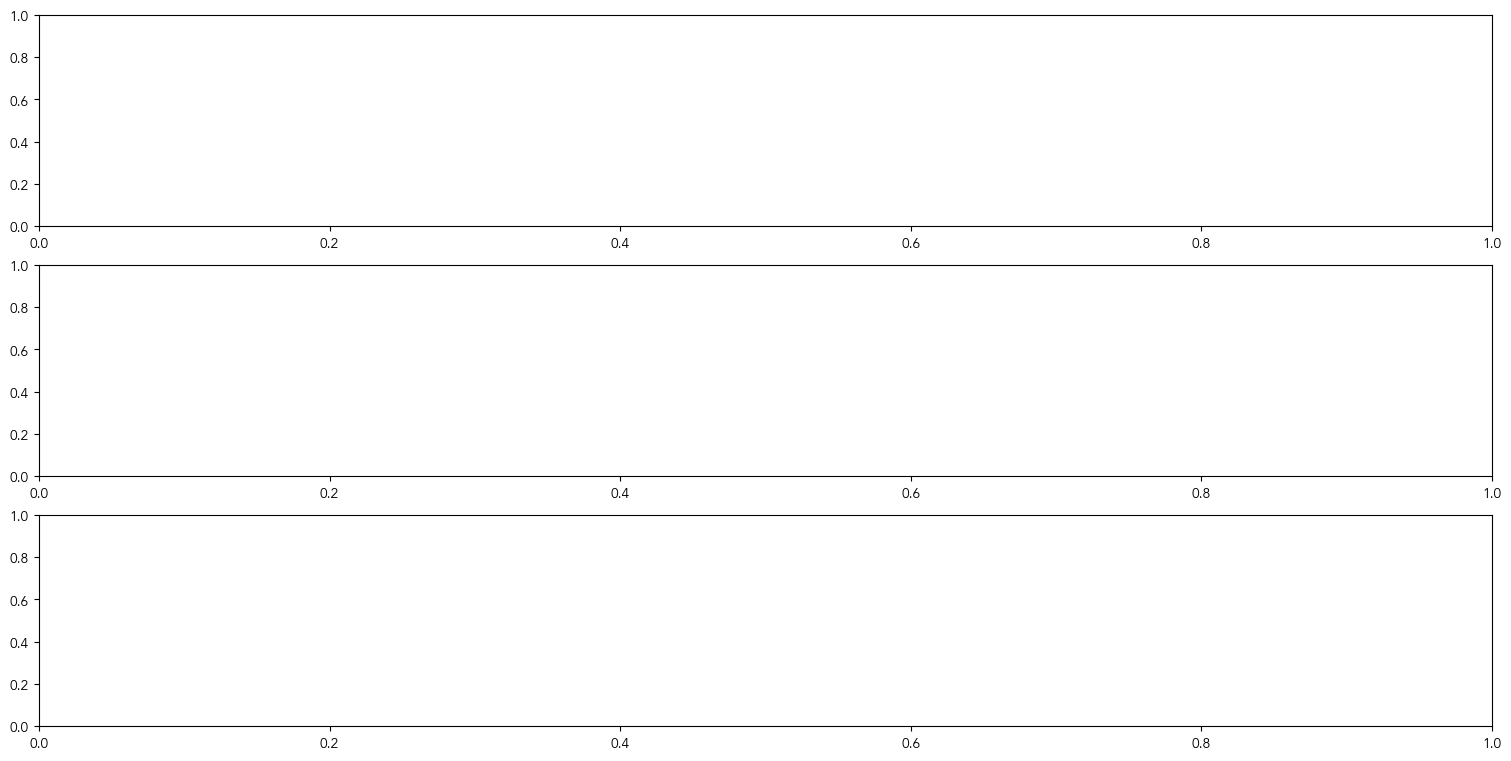

In [113]:
def _plot_forecasts(_ax, F_tr_, E_tr_, M_, f_, w_, idx_, dx_, dt_, t):

    tau_ = dt_[:t]
    s_ = dt_[t:]

    z_ = (w_ - w_[idx_].min()) / (w_[idx_].max() - w_[idx_].min())
    idx_ = idx_[np.argsort(w_[idx_])]
    _cmap = sns.color_palette("flare", as_cmap=True)
    _norm = plt.Normalize(z_[idx_].min(), z_[idx_].max())

    _ax.plot(
        tau_,
        100.0 * f_,
        c=palette_.loc[0, "ibm"],
        clip_on=False,
        zorder=10,
        label="CF (ac)",
        lw=2,
    )

    _ax.plot(
        s_,
        100.0 * f_hat_,
        c=palette_.loc[0, "ibm"],
        clip_on=False,
        zorder=10,
        lw=2,
        ls="--",
    )

    _ax.plot(dt_, 100.0 * e_, clip_on=False, lw=2, zorder=9, label="CF (fc)", c="k")

    _ax.plot([], [], label=r"$E_{\kappa_{\xi}}(t)$", c="orange")

    for i, j in zip(idx_, range(idx_.shape[0])):
        _ax.plot(dt_, 100 * E_tr_[i, :], c=_cmap(_norm(z_[i])), lw=0.75, zorder=8)

    _ax.fill_between(
        tau_,
        100 * np.ones(tau_.shape),
        100 * np.zeros(tau_.shape),
        color="lightgray",
        alpha=0.25,
        zorder=1,
    )

    _ax.axvline(dt_[t - 1], color="k", lw=1.0, zorder=11)

    _ax.set_xticks(dt_[::12], dx_[::12], rotation=22.5)

    _ax.set_ylim(0.0, 100.0)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size=14)

    _ax.tick_params(axis="both", labelsize=12)

    _ax.legend(frameon=False, fontsize=12, ncol=10)


def _plot_scenarios(_ax, F_tr_, E_tr_, M_, f_, w_, idx_, dx_, dt_, t):

    tau_ = dt_[:t]
    s_ = dt_[t:]

    z_ = (w_ - w_[idx_].min()) / (w_[idx_].max() - w_[idx_].min())
    idx_ = idx_[np.argsort(w_[idx_])]
    _cmap = sns.color_palette("flare", as_cmap=True)
    _norm = plt.Normalize(z_[idx_].min(), z_[idx_].max())

    _ax.plot(
        tau_, 100.0 * f_, c=palette_.loc[0, "ibm"], zorder=10, label="CF (ac)", lw=2
    )

    _ax.plot(s_, 100.0 * f_hat_, c=palette_.loc[0, "ibm"], zorder=10, lw=2, ls="--")

    _ax.plot(dt_, 100.0 * e_, lw=2, zorder=9, label="CF (fc)", c="k")

    _ax.plot([], [], label=r"$\mathcal{F}_{\kappa_{\xi}}(t)$", c="orange")

    for i, j in zip(idx_, range(idx_.shape[0])):
        _ax.plot(dt_, 100 * F_tr_[i, :], c=_cmap(_norm(z_[i])), lw=0.75, zorder=8)

    _ax.fill_between(
        tau_,
        100 * np.ones(tau_.shape),
        100 * np.zeros(tau_.shape),
        color="lightgray",
        alpha=0.25,
        zorder=1,
    )

    _ax.axvline(dt_[t - 1], color="k", lw=1.0, zorder=11)

    _ax.set_xticks(dt_[::12], dx_[::12], rotation=22.5)
    _ax.set_ylim(0.0, 100.0)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size=14)

    _ax.tick_params(axis="both", labelsize=12)

    _ax.legend(frameon=False, fontsize=12, ncol=10)


def _plot_updates(_ax, F_tr_, E_tr_, M_, f_, w_, idx_, dx_, dt_, t):

    tau_ = dt_[:t]
    s_ = dt_[t:]

    z_ = (w_ - w_[idx_].min()) / (w_[idx_].max() - w_[idx_].min())
    idx_ = idx_[np.argsort(w_[idx_])]
    _cmap = sns.color_palette("flare", as_cmap=True)
    _norm = plt.Normalize(z_[idx_].min(), z_[idx_].max())

    _ax.plot(
        tau_,
        100.0 * f_,
        c=palette_.loc[0, "ibm"],
        zorder=10,
        label="CF (ac)",
        clip_on=False,
        lw=2,
    )

    _ax.plot(
        s_,
        100.0 * f_hat_,
        c=palette_.loc[0, "ibm"],
        zorder=10,
        lw=2,
        clip_on=False,
        ls="--",
    )

    _ax.plot(dt_, 100.0 * e_, lw=2, zorder=9, label="CF (fc)", clip_on=False, c="k")

    _ax.plot([], [], label=r"$\mu(s)$", c="orange")

    for i, j in zip(idx_, range(M_.shape[0])):
        _ax.plot(dt_[t:], 100 * M_[j, :], c=_cmap(_norm(z_[i])), lw=0.75, zorder=8)

    _ax.fill_between(
        tau_,
        100 * np.ones(tau_.shape),
        100 * np.zeros(tau_.shape),
        color="lightgray",
        alpha=0.375,
        zorder=1,
    )

    _ax.axvline(dt_[t - 1], color="k", lw=1.0, label="event (du)", zorder=8)
    _ax.set_xticks(dt_[::12], dx_[::12], rotation=22.5)
    # ax_[2].set_yticks(size = 12)
    _ax.set_ylim(0.0, 100.0)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size=14)
    _ax.tick_params(axis="both", labelsize=12)
    _ax.legend(frameon=False, fontsize=12, ncol=1)

    cbar = fig.colorbar(
        cm.ScalarMappable(_norm, _cmap),
        cax=_ax.inset_axes([180, 75, 100, 7.5], transform=_ax.transData),
        orientation="horizontal",
        extend="both",
    )

    cbar.set_ticks([0, 1], labels=["low", "high"])
    cbar.ax.tick_params(length=0)
    cbar.ax.set_title("Similarity", rotation=0)


fig, _ax = plt.subplot_mosaic(
    [["a"], ["b"], ["c"]],
    figsize=(15, 7.5),
    layout ="constrained",
)

_plot_forecasts(_ax["a"], F_tr_, E_tr_, M_, f_, w_, idx_2_, dx_, dt_, t)

_plot_scenarios(_ax["b"], F_tr_, E_tr_, M_, f_, w_, idx_2_, dx_, dt_, t)

_plot_updates(_ax["c"], F_tr_, E_tr_, M_, f_, w_, idx_2_, dx_, dt_, t)

plt.savefig(path_to_images + r"/scenarios_fc.png", bbox_inches="tight", dpi=300)

plt.show()

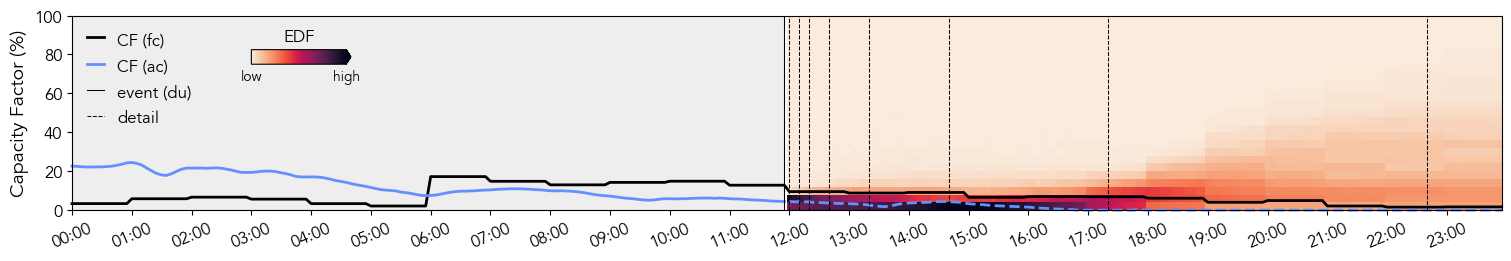

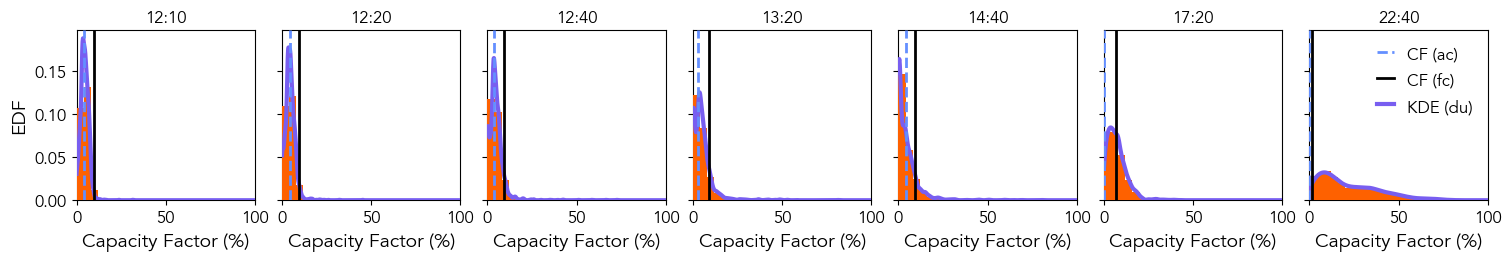

In [266]:
def _plot_histogram_cuts(_ax, M_, f_, e_, f_hat_, dx_, dt_, t, cuts_):

    tau_ = dt_[:t]
    s_ = dt_[t:]

    x_ = np.linspace(0, 100, 1000)[:, np.newaxis]

    for cut, i in zip(cuts_, range(len(cuts_))):
        _KD = KernelDensity(
            bandwidth=_silverman_rule(100 * M_[:, cut]),
            algorithm="auto",
            kernel="gaussian",
        ).fit(100 * M_[:, cut][:, np.newaxis])

        _ax[i].axvline(
            100.0 * f_hat_[cut],
            color=palette_.loc[0, "ibm"],
            lw=2,
            ls="--",
            label="CF (ac)",
            zorder=10,
        )

        _ax[i].axvline(100.0 * e_[t + cut], color="k", lw=2, label="CF (fc)", zorder=10)

        _ax[i].hist(
            100.0 * M_[:, cut],
            bins=25,
            range=(0, 100),
            density=True,
            color=palette_.loc[3, "ibm"],
            zorder=8,
        )

        _ax[i].plot(
            x_,
            np.exp(_KD.score_samples(x_)),
            label="KDE (du)",
            color=palette_.loc[1, "ibm"],
            lw=3,
            zorder=9,
        )

        _ax[i].set_title(dx_[t:][cut])
        _ax[i].set_xlim(0, 100)
        _ax[i].set_ylim(
            0,
        )
        _ax[i].set_xlabel("Capacity Factor (%)", size=14)
        _ax[i].tick_params(axis="both", labelsize=12)

    _ax[0].set_ylabel("EDF", size=14)

    _ax[-1].legend(frameon=False, fontsize=12)


def _plot_density_heatmap(_ax, M_, f_, e_, f_hat_, dx_, dt_, t, cuts_):

    tau_ = dt_[:t]
    s_ = dt_[t:]

    Z_ = []
    for i in range(M_.shape[1]):
        a_, b_ = np.histogram(100.0 * M_[:, i], bins=25, range=(0, 100), density=True)
        Z_.append(a_)

    Z_ = np.stack(Z_).T
    X_, Y_ = np.meshgrid(dt_[t:], (b_[1:] + b_[:-1]) / 2.0)

    _cmap = sns.color_palette("rocket_r", as_cmap=True)
    _ax.pcolormesh(X_, Y_, Z_, cmap=_cmap)

    _ax.plot(dt_, 100.0 * e_, c="k", lw=2.0, label="CF (fc)", clip_on=False)

    _ax.plot(
        tau_,
        100.0 * f_,
        c=palette_.loc[0, "ibm"],
        clip_on=False,
        lw=2.0,
        label="CF (ac)",
    )

    _ax.plot(
        s_, 100.0 * f_hat_, c=palette_.loc[0, "ibm"], clip_on=False, lw=2.0, ls="--"
    )

    _ax.fill_between(
        tau_,
        100.0 * np.ones(tau_.shape),
        100.0 * np.zeros(tau_.shape),
        color="lightgray",
        alpha=0.375,
    )

    _ax.axvline(dt_[t - 1], color="k", linewidth=0.75, label="event (du)")

    _ax.axvline(dt_[t], color="k", lw=0.75, ls="--", label="detail")

    for cut in cuts_:
        _ax.axvline(dt_[t + cut], color="k", lw=0.75, ls="--")

    _ax.set_xticks(dt_[::12], dx_[::12], rotation=22.5)
    _ax.set_ylabel("Capacity Factor (%)", size=14)

    _ax.tick_params(axis="both", labelsize=12)

    _ax.set_ylim(0.0, 100.0)
    _ax.set_xlim(dt_[0], dt_[-1])

    _ax.legend(frameon=False, fontsize=12, ncol=1)

    cbar = fig.colorbar(
        cm.ScalarMappable(cmap=_cmap),
        cax=_ax.inset_axes([180, 75, 100, 7.5], transform=_ax.transData),
        orientation="horizontal",
        extend="max",
    )

    cbar.set_ticks([0, 1], labels=["low", "high"])
    cbar.ax.tick_params(length=0)

    cbar.ax.set_title("EDF", rotation=0)

cuts_ = [2, 4, 8, 16, 32, 64, 128]

fig, _ax = plt.subplots(1, 1, figsize=(15, 2.5), layout="constrained")

_plot_density_heatmap(_ax, M_, f_, e_, f_hat_, dx_, dt_, t, cuts_)

plt.savefig(path_to_images + r"/eCDF_heatmap.pdf", bbox_inches="tight", dpi=300)

plt.show()

fig, _ax = plt.subplots(
    1, len(cuts_), figsize=(15, 2.5), sharey=True, layout="constrained"
)

_plot_histogram_cuts(_ax, M_, f_, e_, f_hat_, dx_, dt_, t, cuts_)

plt.savefig(path_to_images + r"/hist_cutoffs.pdf", bbox_inches="tight", dpi=300)

plt.show()

144 0 0
(251, 145)


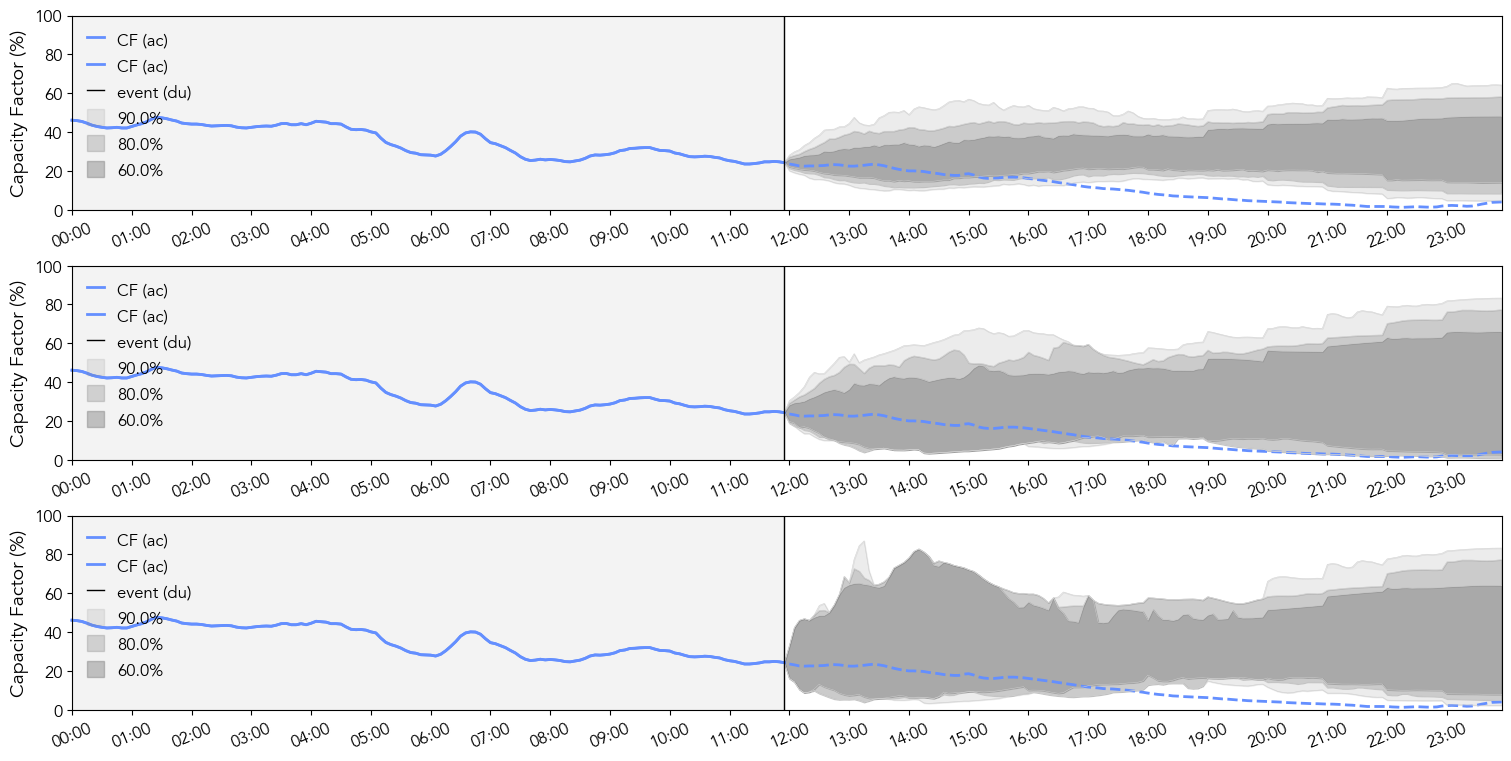

In [57]:
def _plot_fEnvelop(_ax, _upper, _lower, M_, f_, e_, f_hat_, dt_, dx_, tau_, s_, s_p_, t, legend = True):

    _ax.plot(
        tau_, 100 * f_, c=palette_.loc[0, "ibm"], label="CF (ac)", lw=2.0, clip_on=False
    )

    _ax.plot(
        tau_,
        100.0 * f_,
        c       = palette_.loc[0, "ibm"],
        label   = "CF (ac)",
        lw      = 2.0,
        clip_on = False,
    )

    _ax.plot(
        s_, 100.0 * f_hat_, c=palette_.loc[0, "ibm"], ls="--", lw=2.0, clip_on=False
    )

    _ax.axvline(dt_[t - 1], 
                color="k", 
                linewidth=1.0, 
                label  = "event (du)", 
                zorder = 10)

    for key, i in zip(_upper.keys(), range(len(_upper.keys()))):
        
        _ax.plot(s_p_, _upper[key], lw = 0.375, c = "lightgray")
        _ax.plot(s_p_, _lower[key], lw = 0.375, c = "lightgray")

        alpha = float(key)
        ci    = (1. - alpha)*100.
        
        _ax.fill_between(
            s_p_,
            _upper[key],
            _lower[key],
            color  = "gray",
            alpha  = 0.15 + i * 0.15,
            label  = f"{ci}%",
            zorder = 1,
        )

    _ax.fill_between(
        tau_,
        100 * np.ones(tau_.shape),
        100 * np.zeros(tau_.shape),
        color = "lightgray",
        alpha = 0.25,
    )

    _ax.set_xticks(dt_[::12], dx_[::12], rotation=22.5)
    
    if legend: _ax.legend(frameon  = False,
                          fontsize = 12,
                          ncol     = 1)
        
    _ax.tick_params(axis="both", labelsize=12)
    _ax.set_ylim(0.0, 100.0)
    _ax.set_xlim(dt_[0], dt_[-1])
    _ax.set_ylabel("Capacity Factor (%)", size=14)
    # plt.grid(axis = 'y', linestyle = ':', lw = 1., zorder = 10)

# Extend quantiles to a dynamic update event
M_p_ = np.concatenate([f_[-1] * np.ones((M_.shape[0], 1)), M_], axis=1)
s_p_ = np.concatenate([tau_[-1] * np.ones((1,)), s_], axis=0)

fig, _ax = plt.subplot_mosaic(
    [["a"], ["b"], ["c"]],
    figsize = (15, 7.5),
    layout  = "constrained")
print(t, a, d)
# Calculate confidence intervals from functional depth metrics
m_, _upper, _lower = _confidence_intervals_from_eCDF(M_p_, alpha_)

_plot_fEnvelop(_ax["a"], _upper, _lower, M_p_, f_, e_, f_hat_, dt_, dx_, tau_, s_, s_p_, t)

# Calculate confidence intervals from Directional Quantiles
m_, _upper, _lower = _confidence_intervals_from_DQ(M_p_, alpha_)

_plot_fEnvelop(_ax["b"], _upper, _lower, M_p_, f_, e_, f_hat_, dt_, dx_, tau_, s_, s_p_, t)

# Calculate confidence intervals from the functional depth metric
m_, _upper, _lower = _confidence_intervals_from_MBD(M_p_, alpha_)

_plot_fEnvelop(_ax["c"], _upper, _lower, M_p_, f_, e_, f_hat_, dt_, dx_, tau_, s_, s_p_, t)

plt.savefig(path_to_images + r"/fEnvelop.pdf", bbox_inches="tight", dpi=600)

plt.show()

# Dynamic Forcasting Cone 

In [ ]:
def _fknn_forecast_dynamic_update(F_tr_, E_tr_, x_tr_, dt_, f_, e_, x_, f_hat_,
                                  forget_rate_f  = 1.,
                                  forget_rate_e  = .5,
                                  length_scale_f = .1,
                                  length_scale_e = .75,
                                  lookup_rate    = .05,
                                  trust_rate     = .005,
                                  gamma          = .2,
                                  xi             = 0.99,
                                  kappa_min      = 100,
                                  kappa_max      = 1000):


    # Get constants
    t    = f_.shape[0]
    tau_ = dt_[:t]
    s_   = dt_[t:]

    # phi: importance weights based on past time distance
    phi_ = _exponential_growth(t, forget_rate_f)

    # psi: importance weights based on past and future time distance
    psi_1_ = _exponential_growth(t, forget_rate_e)
    psi_2_ = _exponential_decay(T - t, lookup_rate)
    psi_   = np.concatenate([psi_1_, psi_2_], axis = 0)
    
    # d: Euclidean distance between samples weighted by importance weights
    d_f_ = _euclidian_dist(F_tr_[:, :t], f_, w_ = phi_)
    d_e_ = _euclidian_dist(E_tr_, e_, w_ = psi_)
    d_h_ = _haversine_dist(x_ts_[a, :], x_tr_)
    d_p_ = _periodic_dist(t_tr_[d], t_tr_)

    # w: normalized weights distance across observations based on the exponential link function
    w_f_ = _kernel(d_f_, length_scale_f)
    w_e_ = _kernel(d_e_, length_scale_e)
    W_   = np.stack([w_f_, w_e_])

    w_, idx_rank_, idx_bool_, idx_1_, idx_2_, xi, gamma, sigma, status = _scenario_filtering(W_, 
                                                                                         d_h_, 
                                                                                         d_p_, 
                                                                                         xi, 
                                                                                         gamma, 
                                                                                         kappa_min, 
                                                                                         kappa_max)

    # eta: importance weights based on future time distance
    rmse  = np.sqrt(np.mean((e_[:t] - f_)**2))
    wrmse = np.sqrt(np.sum(psi_1_*(e_[:t] - f_)**2)/psi_1_.sum())
    nu    = np.sqrt(rmse)*2750
    if nu < 875: nu = 875
    #print(rmse, wrmse)

    eta_ = _logistic(s_ - nu, k = trust_rate)

    # Fuse scenarios with day-ahead forecasts
    M_ = np.zeros((idx_2_.shape[0], eta_.shape[0]))
    for i, j in zip(idx_2_, range(idx_2_.shape[0])):
        M_[j, :] = F_tr_[i, t:]*(1. - eta_) + E_tr_[i, t:]*eta_

    return M_, phi_, psi_, eta_


a = 1
d = 0

intervals_ = [72, 108, 144, 180, 216]
alpha_     = [0.1, 0.2, 0.4]

fig, _ax = plt.subplot_mosaic(
    [["a"], ["b"], ["c"], ["d"], ["e"]],
    figsize = (15, 12.5),
    sharex  = True,
    layout  = "constrained")

for t, key in zip(intervals_, _ax.keys()):
    file_name = f'{a}-{d}-{t}'
    print(file_name)
    
    f_     = F_ts_[d, :t, a]
    e_     = E_ts_[d, :, a]
    x_     = x_ts_[a, :]
    f_hat_ = F_ts_[d, t:, a]
    
    # Get constants
    tau_ = dt_[:t]
    s_   = dt_[t:]
    
    M_, phi_, psi_, eta_ = _fknn_forecast_dynamic_update(F_tr_, E_tr_, x_tr_, dt_, f_, e_, x_, f_hat_, 
                                                         forget_rate_f  = 1.,
                                                         forget_rate_e  = .5,
                                                         length_scale_f = .1,
                                                         length_scale_e = .75,
                                                         lookup_rate    = .05,
                                                         trust_rate     = .005,
                                                         xi             = 0.99,
                                                         gamma          = .2)
    

    # Extend quantiles to a dynamic update event
    M_p_ = np.concatenate([f_[-1] * np.ones((M_.shape[0], 1)), M_], axis=1)
    s_p_ = np.concatenate([tau_[-1] * np.ones((1,)), s_], axis=0)

    m_, _upper, _lower = _confidence_intervals_from_eCDF(M_p_, alpha_)

    _plot_fEnvelop(_ax[key], _upper, _lower, M_p_, f_, e_, f_hat_, dt_, dx_, tau_, s_, s_p_, t,
                  legend = True)

#plt.savefig(path_to_images + r"/dynamic_forecasting_cone.pdf", bbox_inches="tight", dpi=600)

plt.show()

(251, 144)
[1.42179915 1.41564031 1.00982286 1.28722403 1.08902397 1.04096022
 0.91193186 1.41770827 1.1042304  0.97088207 1.28444813 2.24202633
 2.0368056  1.3408083  0.79245627 1.08182585 1.49534844 2.3275736
 0.40047058 0.67327317 1.14304767 1.28191645 1.39081825 1.3236161
 1.54232524 1.00556948 2.25397476 1.5740507  0.98547075 1.92363435
 0.80152083 1.06019936 1.44100815 1.28791912 0.90631742 0.95864806
 2.43903737 1.02170381 1.04659386 2.06169334 0.89312755 1.39836535
 0.80070695 0.73617537 0.57749821 1.62229926 0.80235616 0.89884243
 1.05073068 1.59394708 1.25479815 0.75805317 1.48464142 1.1441372
 0.95610919 0.92490702 0.96414824 0.79742547 0.92423753 1.16023985
 0.82382147 0.6616043  1.20699693 2.49781839 1.17184467 1.03787521
 0.96851723 0.58156607 0.89057398 1.02670485 0.96574775 1.13005322
 1.13076508 1.01105998 0.93071882 1.49374888 1.65428198 1.59325759
 3.25339705 1.53846511 1.33806213 1.60352511 0.96712968 1.03900567
 1.15120069 0.72754256 1.03794034 0.62247674 0.5794187

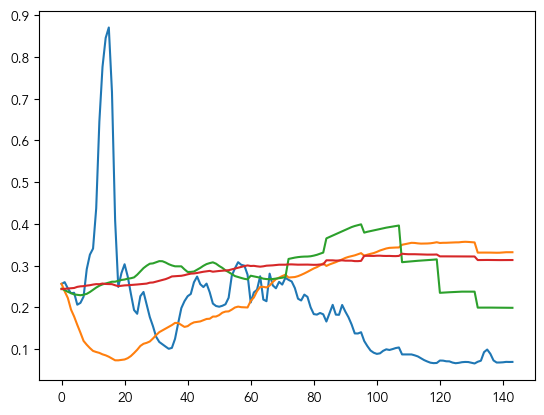

(144,)
0.03212691585887753
[0.63194444 0.63194444 0.46527778]


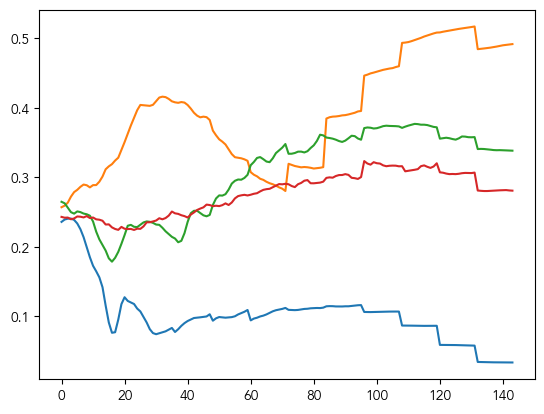

(144,)
0.03868558552313065
[0.51388889 0.47916667 0.41666667]
(144,)
0.041498587223563914
[0.39583333 0.34027778 0.26388889]


In [68]:
def _directional_quantile(curves, q_lower=0.025, q_upper=0.975):
    """
    Compute directional quantile outlyingness for each curve.

    Parameters
    ----------
    curves: np.ndarray, shape (n, T)
        Functional data: n curves sampled at T points.
    q_lower: float
        Lower quantile for scaling (default 0.025).
    q_upper: float
        Upper quantile (default 0.975).

    Returns
    -------
    dq : np.ndarray, shape (n,)
        Directional quantile (max scaled deviation) per curve.
    """
    n, T   = curves.shape
    mean_t = np.mean(curves, axis=0)
    lower  = np.quantile(curves, q_lower, axis=0)
    upper  = np.quantile(curves, q_upper, axis=0)

    # Avoid division by zero: float eps
    denom_low = mean_t - lower
    denom_up  = upper - mean_t
    denom_low[denom_low == 0] = np.finfo(float).eps
    denom_up[denom_up == 0]   = np.finfo(float).eps

    # Compute scaled deviations for each curve at each time
    diffs = curves - mean_t  # (n,T)
    scaled = np.where(diffs >= 0,
                      np.abs(diffs) / denom_up,
                      np.abs(diffs) / denom_low)

    return np.max(scaled, axis=1)

def _modified_band_depth(curves):
    """
    Compute Modified Band Depth (J=2) using vectorized NumPy operations.
    
    Parameters:
    -----------
    curves: ndarray, shape (n_samples, n_times)
        Functional data matrix.
    
    Returns:
    --------
    mbd: ndarray, shape (n_samples,)
        MBD scores for each function.
    """
    n, T  = curves.shape
    pairs = np.array([(j, k) for j in range(n) for k in range(j+1, n)])
    lower = np.minimum(curves[pairs[:, 0]][:, None, :], curves[pairs[:, 1]][:, None, :])
    upper = np.maximum(curves[pairs[:, 0]][:, None, :], curves[pairs[:, 1]][:, None, :])
    mbd   = np.zeros(n)
    
    # Check inclusion across all bands and time points
    for i in range(n):
        inside = np.logical_and(lower <= curves[i], curves[i] <= upper)
        mbd[i] = inside.sum() / (len(pairs) * T)
    
    return mbd

def _empirical_interval_score(y_true, y_pred_lower, y_pred_upper, alpha):
    """
    Calculate the interval score for probabilistic forecasts with an interval [lower, upper].
    
    Parameters:
    - y_true: Observed (true) values
    - y_pred_upper: upper confidence interval for significance level alpha
    - y_pred_lower: low confidence interval for significance level alpha
    - alpha: Significance level (default 0.05 for 90% confidence interval)
    
    Returns:
    - interval_score: The calculated interval score
    """
        
    # Penalty for observation outside the lower bound
    penalty_lower = 2.*np.maximum(0, y_pred_lower - y_true)/alpha
    
    # Penalty for observation outside the upper bound
    penalty_upper = 2.*np.maximum(0, y_true - y_pred_upper)/alpha
    
    # Interval width penalty
    penalty_width = y_pred_upper - y_pred_lower
    
    # Total interval score
    return penalty_lower + penalty_upper + penalty_width

def _eQuantile(_eCDF, q_):
    """
    Calculates quantiles from an ECDF.

    Args:
    _eCDF: function from statsmodels api
    q_: A list or numpy array of quantiles to calculate (values between 0 and 1).

    Returns:
    _Q: A dictionary where keys are the input quantiles and values are the corresponding
    Quantile values from the ECDF.
    """

    return np.array([_eCDF.x[np.searchsorted(_eCDF.y, q)] for q in q_])

# Derive confidence intervals from Directional Quantiles
def _confidence_intervals_from_DQ(M_, alpha_, zeta = 1.):
    print(M_.shape)
    
    _y_pred_upper = {}
    _y_pred_lower = {}
    for i in range(len(alpha_)):
        # Calculate functional Directional Quantiles (DQ)
        DQ_ = _directional_quantile(M_, 
                                    q_lower = alpha_[i]/2., 
                                    q_upper = 1. - alpha_[i]/2.)
        print(DQ_)
        I_  = np.argsort(DQ_)[::-1]
    
        scen_                         = M_[I_[int(M_.shape[0] * zeta * alpha_[i]):],]
        _y_pred_upper[f'{alpha_[i]}'] = np.max(scen_, axis = 0)
        _y_pred_lower[f'{alpha_[i]}'] = np.min(scen_, axis = 0)

    m_ = np.mean(M_, axis = 0)

    plt.figure()
    plt.plot(M_[I_[0], :])
    plt.plot(M_[I_[120], :])
    plt.plot(M_[I_[-1], :])
    plt.plot(m_)
    plt.show()

    return m_, _y_pred_upper, _y_pred_lower

# Derive confidence intervals from a functional depth metric
def _confidence_intervals_from_MBD(M_, alpha_, zeta = 1.):

    # Calculate Modified Band Depth ranking
    MBD_ = _modified_band_depth(M_)
    I_   = np.argsort(MBD_)

    _y_pred_upper = {}
    _y_pred_lower = {}
    for i in range(len(alpha_)):
        scen_                         = M_[I_[int(M_.shape[0] * zeta * alpha_[i]) :],]
        _y_pred_upper[f'{alpha_[i]}'] = np.max(scen_, axis = 0)
        _y_pred_lower[f'{alpha_[i]}'] = np.min(scen_, axis = 0)

    m_ = np.median(M_, axis = 0)

    plt.figure()
    plt.plot(M_[I_[0], :])
    plt.plot(M_[I_[120], :])
    plt.plot(M_[I_[-1], :])
    plt.plot(m_)
    plt.show()
    
    return m_, _y_pred_upper, _y_pred_lower

# Derive confidence intervals from a functional depth metric
def _confidence_intervals_from_eCDF(M_, alpha_, zeta = 1.):    

    _y_pred_upper = {}
    _y_pred_lower = {}
    for i in range(len(alpha_)):

        _y_pred_lower[f'{alpha_[i]}'] = np.stack([_eQuantile(ECDF(M_[:, j]), [alpha_[i]/2.])
                                                  for j in range(M_.shape[1])])[:, 0]
        _y_pred_upper[f'{alpha_[i]}'] = np.stack([_eQuantile(ECDF(M_[:, j]), [1. - alpha_[i]/2.])
                                                  for j in range(M_.shape[1])])[:, 0]

    m_ = np.median(M_, axis = 0)

    return m_, _y_pred_upper, _y_pred_lower

def _weighted_interval_score(y_true, y_pred, _y_pred_lower, _y_pred_upper, alpha_):
    """
    Calculate the interval score for probabilistic forecasts with an interval [lower, upper].
    
    Parameters:
    - y_true: Observed (true) values
    - _y_pred_lower: dictionary with upper confidence interval for all significance levels alpha
    - _y_pred_lower: dictionary with lower confidence interval for all significance levels alpha
    - alpha: all significance level alpha (default 0.05 for 90% confidence interval)

    Returns:
    - WIS: float, the Weighted Interval Score.
    """

    # Calculate the interval score
    w0  = 1/2.
    w_  = np.array(alpha_)/2.
    is_ = np.zeros((y_true.shape[0], w_.shape[0]))
    for i in range(len(alpha_)):
        is_[:, i] = _empirical_interval_score(y_true, 
                                              _y_pred_lower[f'{alpha_[i]}'],
                                              _y_pred_upper[f'{alpha_[i]}'], 
                                               alpha_[i])
    
    term0 = 1./(len(alpha_) + 1/2.)
    term1 = w0 * np.absolute(y_true - y_pred)

    for i in range(w_.shape[0]):
        is_[:, i] = w_[i] * is_[:, i]
    term2 = np.sum(is_, axis = 1)
        
    return term1 * (term1 + term2)

def _empirical_coverage_score(y_true, _lower, _upper, alpha_):
    """`
    Calculate the coverage score for probabilistic forecasts with an interval [lower, upper]
    
    Parameters:
    - y_: Observed (true) values
    - lower_: upper confidence bound
    - upper_: lower confidence dound
    
    Returns:
    - coverage_score: The calculated interval score
    """

    def _converage_score(y_true, lower_, upper_):
        coverage = 0
        for i in range(y_true.shape[0]): 
            if (y_true[i] < lower_[i]) or (y_true[i] > upper_[i]):
                coverage += 0
            else:
                coverage += 1
        return coverage / y_true.shape[0]


    cs_ = np.zeros((len(alpha_),))
    for i in range(len(alpha_)):
        cs_[i] = _converage_score(y_true, _lower[f'{alpha_[i]}'], _upper[f'{alpha_[i]}'])
    
    return cs_
    
MBD_ = _modified_band_depth(M_)

alpha_ = [0.1, 0.2, 0.4]
# Calculate confidence intervals from Directional Quantiles
m_, _upper, _lower = _confidence_intervals_from_DQ(M_, alpha_)
print(m_.shape)

WIS_ = _weighted_interval_score(f_hat_, m_, _lower, _upper, alpha_)
print(WIS_.mean())

CS = _empirical_coverage_score(f_hat_, _lower, _upper, alpha_)
print(CS)

# Calculate confidence intervals from functional depth metrics
m_, _upper, _lower = _confidence_intervals_from_MBD(M_, alpha_)
print(m_.shape)

# Calculate confidence intervals from functional depth metrics
WIS_ = _weighted_interval_score(f_hat_, m_, _lower, _upper, alpha_)
print(WIS_.mean())

CS = _empirical_coverage_score(f_hat_, _lower, _upper, alpha_)
print(CS)

m_, _upper, _lower = _confidence_intervals_from_eCDF(M_, alpha_)
print(m_.shape)

# Calculate confidence intervals from functional depth metrics
WIS_ = _weighted_interval_score(f_hat_, m_, _lower, _upper, alpha_)
print(WIS_.mean())

CS = _empirical_coverage_score(f_hat_, _lower, _upper, alpha_)
print(CS)

In [ ]:
# Derive confidence intervals from Directional Quantiles
def _confidence_intervals_from_DQ(M_, alpha_, path):
    print(M_.shape)
    # Calculate functional Directional Quantiles (DQ)
    DQ_ = _fQuantile(M_, path).to_numpy()[:, ::-1]


    _y_pred_upper = {}
    _y_pred_lower = {}
    for i in range(len(alpha_)):
        scen_                         = 100.0 * M_[DQ_[:, i] <= 1.0]
        _y_pred_upper[f'{alpha_[i]}'] = np.max(scen_, axis = 0)
        _y_pred_lower[f'{alpha_[i]}'] = np.min(scen_, axis = 0)

    m_ = np.mean(M_, axis = 0)

    return m_, _y_pred_upper, _y_pred_lower

# Derive confidence intervals from a functional depth metric
def _confidence_intervals_from_fDepth(M_, alpha_, depth, path):

    # Calculate functional depth ranking
    D_ = _fDepth(M_, depth, path).to_numpy()[:, 0]
    I_ = np.argsort(D_)

    _y_pred_upper = {}
    _y_pred_lower = {}
    for i in range(len(alpha_)):
        scen_                         = 100.0 * M_[I_[int(M_.shape[0] * alpha_[i]) :],]
        _y_pred_upper[f'{alpha_[i]}'] = np.max(scen_, axis = 0)
        _y_pred_lower[f'{alpha_[i]}'] = np.min(scen_, axis = 0)

    m_ = np.median(M_, axis = 0)

    return m_, _y_pred_upper, _y_pred_lower

In [ ]:
def _PIT_gaussian(y_true, forecast_mean, forecast_std, nbins=100):
    """
    Calculate the Probabilistic Integral Transform (PIT).

    Parameters:
    - y_true: Observed (true) values
    - forecast_mean: Mean of the predicted distribution (e.g., mean of the normal distribution)
    - forecast_std: Standard deviation of the predicted distribution

    Returns:
    - mean and std: The calculated PIT
    """

    u_samples = norm.cdf(y_true, loc=forecast_mean, scale=forecast_std)

    # Plot the histogram of U to check if it's uniformly distributed
    plt.figure(figsize=(12.5, 2.5))
    plt.hist(
        u_samples,
        bins=nbins,
        density=True,
        alpha=0.7,
        color="blue",
        label="Transformed (U)",
    )

    plt.hlines(1, 0, 1, color="red", linestyle="--", label="Uniform distribution")

    plt.title("Probabilistic Integral Transform")
    plt.xlabel("U")
    plt.ylabel("PDF")
    plt.legend()


def _PIT(z_, nbins=100, file_name="unnamed.png"):
    """
    Calculate the Probabilistic Integral Transform (PIT).

    Parameters:
    - z_: CDF evaluations
    - nbins: number of bins in the histogram
    """

    # Plot the histogram of U to check if it's uniformly distributed
    plt.figure(figsize=(5, 2.5))
    plt.hist(
        z_, bins=nbins, density=True, alpha=0.7, color="blue", label="Transformed (U)"
    )

    plt.hlines(1, 0, 1, color="red", linestyle="--", label="Uniform distribution")
    plt.ylim(
        0.0,
        2,
    )

    plt.title("Probabilistic Integral Transform")
    plt.xlabel("U")
    plt.ylabel("PDF")
    plt.legend()

    plt.savefig(path_to_images + r"/{}".format(file_name), bbox_inches="tight", dpi=300)


def _KS(z_, nbins=100):
    """
    Calculate the Kolmogorov–Smirnov (KS) statistic for a normal dist.

    Parameters:
    - y_true: Observed (true) values
    - forecast_mean: Mean of the predicted distribution (e.g., mean of the normal distribution)
    - forecast_std: Standard deviation of the predicted distribution

    Returns:
    - sup_ks: Kolmogorov–Smirnov statistic
    - avg_ks: Kolmogorov–Smirnov statistic but calculating RMSE instead of sup

    """

    # u_samples_  = norm.cdf(y_true, loc = forecast_mean, scale = forecast_std)
    hist_, bin_ = np.histogram(z_, nbins, density=True)
    bins_ = (bin_[:-1] + bin_[1:]) / 2.0
    # r_ = np.cumsum(hist_) - np.cumsum(np.ones(bins_.shape))

    plt.figure()
    plt.plot(np.cumsum(hist_))
    plt.plot(np.cumsum(np.ones(bins_.shape)))
    plt.show()

    # avg_ks = np.sqrt(np.mean((np.cumsum(hist_) - np.cumsum(np.ones(bins_.shape)))**2))/hist_.shape[0]
    sup_ks = np.max(np.absolute(np.cumsum(hist_) - np.cumsum(np.ones(bins_.shape))))

    return sup_ks

In [28]:
t = 144
forget_rate = 2
n_kNNs = 500
i = 48
z_1_ = []

for a in range(20):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(
            F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t
        )

        f_fc_ts_ = F_fc_ts_[d, t:, a]
        f_fc_tr_ = F_fc_ts_[d, :t, a]

        _model = _fit(F_tr_, F_ts_, forget_rate=forget_rate, n_kNNs=n_kNNs)

        _model = _predict(_model, F_hat_ts_, f_tr_)

        # for i in range(48):
        _eCDF = ECDF(_model["F_"][:, i])
        if _eCDF(f_ts_[i]) == 1.0:
            continue
        else:
            # z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))
            z_1_.append(_eCDF(f_ts_[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


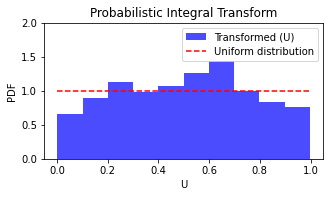

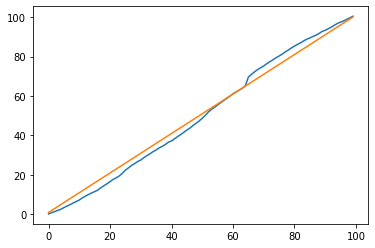

4.70764399316343

In [29]:
_PIT(
    np.stack(z_1_),
    nbins=10,
    file_name="{}_{}_{}-PIT-48.png".format(t, forget_rate, n_kNNs),
)
_KS(np.stack(z_1_), nbins=100)

In [30]:
t = 144
forget_rate = 2
n_kNNs = 500
i = 24

z_2_ = []

for a in range(20):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(
            F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t
        )

        #         f_fc_ts_ = F_fc_ts_[d, t:, a]
        #         f_fc_tr_ = F_fc_ts_[d, :t, a]

        _model = _fit(F_tr_, F_ts_, forget_rate=forget_rate, n_kNNs=n_kNNs)

        _model = _predict(_model, F_hat_ts_, f_tr_)

        # for i in range(48):
        _eCDF = ECDF(_model["F_"][:, i])
        if (_eCDF(f_ts_[i]) == 0.0) | (_eCDF(f_ts_[i]) == 1.0):
            continue
        else:
            # z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))
            z_2_.append(_eCDF(f_ts_[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


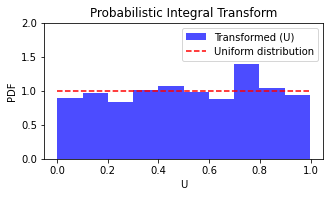

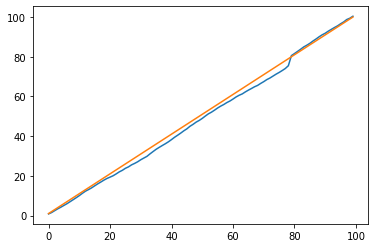

3.959867361862436

In [31]:
_PIT(
    np.stack(z_2_),
    nbins=10,
    file_name="{}_{}_{}-PIT-24.png".format(t, forget_rate, n_kNNs),
)
_KS(np.stack(z_2_), nbins=100)

In [32]:
t = 144
forget_rate = 2
n_kNNs = 500
i = 12
z_3_ = []

for a in range(20):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(
            F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t
        )

        # f_fc_ts_ = F_fc_ts_[d, t:, a]
        # f_fc_tr_ = F_fc_ts_[d, :t, a]

        _model = _fit(F_tr_, F_ts_, forget_rate=forget_rate, n_kNNs=n_kNNs)

        _model = _predict(_model, F_hat_ts_, f_tr_)

        # for i in range(48):
        _eCDF = ECDF(_model["F_"][:, i])
        if _eCDF(f_ts_[i]) == 1.0:
            continue
        else:
            # z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))
            z_3_.append(_eCDF(f_ts_[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


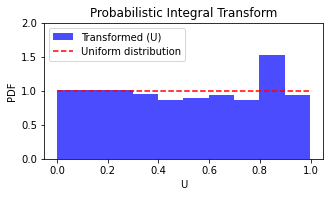

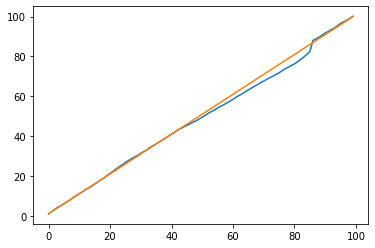

4.725702333503818

In [33]:
_PIT(
    np.stack(z_3_),
    nbins=10,
    file_name="{}_{}_{}-PIT-12.png".format(t, forget_rate, n_kNNs),
)
_KS(np.stack(z_3_), nbins=100)

In [34]:
t = 144
forget_rate = 2
n_kNNs = 500

i = 60
z_4_ = []

for a in range(20):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(
            F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t
        )

        # f_fc_ts_ = F_fc_ts_[d, t:, a]
        # f_fc_tr_ = F_fc_ts_[d, :t, a]

        _model = _fit(F_tr_, F_ts_, forget_rate=forget_rate, n_kNNs=n_kNNs)

        _model = _predict(_model, F_hat_ts_, f_tr_)

        # for i in range(36):
        _eCDF = ECDF(_model["F_"][:, i])
        if _eCDF(f_ts_[i]) == 1.0:
            continue
        else:
            # z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))
            z_4_.append(_eCDF(f_ts_[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


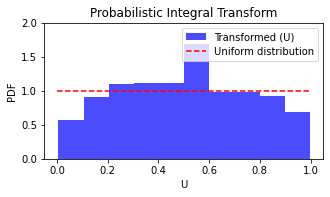

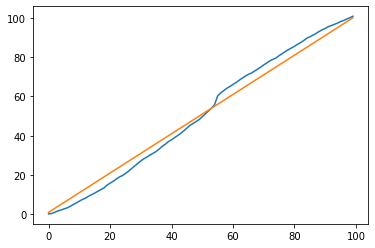

5.577859645969987

In [35]:
_PIT(
    np.stack(z_4_),
    nbins=10,
    file_name="{}_{}_{}-PIT-60.png".format(t, forget_rate, n_kNNs),
)
_KS(np.stack(z_4_), nbins=100)

In [ ]:
# # Forecast dynamic update based on distance
# def _ffc_predict(_model, f_, fc_):

#     F_ = _model['F_tr_']

#     # Smoothing observed mean and actuals
#     if (_model['smoothing'] == 1) | (_model['smoothing'] == 3):
#         F_, f_ = _smoothing(F_, f_, _model['lambda'])

#     # phi: importance weights based on time distance
#     phi_ = _exponential_decay_minus(f_.shape[0], _model['forget_rate'])

#     # plt.figure(figsize = (10, 2))
#     # plt.title('Forget Rate')
#     # plt.plot(phi_)
#     # plt.ylim(-0.1,1.1)
#     # plt.show()

#     # d: euclidian distance between samples weighted by importance weights (phi)
#     d_ = _dist(F_, f_, phi_/phi_.sum())
#     # w: normalized wieghts distance across observations based on RBF kernel distance
#     w_ = _kernel(d_, _model['length_scale'])

#     _model['weights'] = w_/w_.sum()

#     # Multivariate normal assumption
#     _model = _predictive_multivariate_normal_dist(_model, fc_)

#     return _model

# Multivariate normal forecast assumption
# def _predictive_multivariate_normal_dist(_model, fc_):

#     F_ = _model['F_ts_']
#     w_ = _model['weights']

#     # Mean function
#     f_hat_ = F_.T @ w_

#     # Regulate mean function
#     f_hat_ = _gen_constraint(f_hat_, _model['f_min'], _model['f_max'])

#     # Smoothing prediction: unobserved mean and actuals
#     if (_model['smoothing'] == 2) | (_model['smoothing'] == 3):
#         F_, f_hat_ = _smoothing(F_, f_hat_, _model['lambda'])

#     # Fuse day-ahead forecast with real-time forecast
#     mu_hat_ = _update_forecast(F_, f_hat_, fc_, _model['trust_rate'])

#     # Covariance function
#     F_hat_ = np.repeat(mu_hat_[:, np.newaxis], F_.shape[0], axis = 1).T
#     S_hat_ = (F_ - F_hat_).T @ np.diag(w_) @ (F_ - F_hat_)

#     # plt.figure(figsize = (10, 2))
#     # plt.plot(f_hat_, label = 'real-time (fc)')
#     # plt.plot(fc_, label = 'day-ahead (fc)')
#     # plt.plot(mu_hat_, label = 'update (fc)')
#     # plt.ylim(-0.1,)
#     # plt.legend()
#     # plt.show()

#     # Define probability dist
#     _N = multivariate_normal(mu_hat_, S_hat_, allow_singular = True)

#     _model['normal'] = {}
#     _model['normal']['mean']         = mu_hat_
#     _model['normal']['covariance']   = S_hat_
#     _model['normal']['distribution'] = _N

#     return _model.copy()

In [ ]:
# def _fneighborhood_v0(d_f_, d_e_, w_f_, w_e_, w_, idx_0_, idx_1_, idx_2_, xi):

#     #_cmap = plt.get_cmap('gnuplot')
#     _cmap = sns.color_palette("rocket_r", as_cmap = True)
#     _norm = plt.Normalize(w_.min(), w_.max())

#     fig, ax_ = plt.subplots(1, 3,
#                             figsize = (15, 5),
#                             layout  = 'constrained')

#     ax_[0].plot(d_f_[np.argsort(d_f_)], w_f_[np.argsort(d_f_)],
#                 c     = palette_.loc[0, 'ibm'],
#                 label = 'f')
#     ax_[0].plot(d_e_[np.argsort(d_e_)], w_e_[np.argsort(d_e_)],
#                 c     = palette_.loc[3, 'ibm'],
#                 label = 'e')

#     ax_[0].axhline(xi,
#                    color  = 'k',
#                    lw     = 1.,
#                    label  = r'$\xi$',
#                    zorder = 10)

#     ax_[0].set_ylabel(r'$\varphi_{\lambda} (r)$', size = 14)
#     ax_[0].set_xlabel(r'$r$', size = 14)

#     ax_[0].tick_params(axis      = 'both',
#                        labelsize = 12)

#     ax_[0].legend(frameon = False)
#     #plt.xlim(0, 1)
#     #plt.ylim(0, 1)

#     ax_[1].scatter(w_f_, w_e_,
#                    c     = _cmap(_norm(w_)),
#                    s     = 1.,
#                    alpha = 0.5)

#     ax_[1].set_ylabel(r'$\varphi_{\lambda_e} (r_{e})$', size = 14)
#     ax_[1].set_xlabel(r'$\varphi_{\lambda_f} (r_{f})$', size = 14)
#     ax_[1].tick_params(axis      = 'both',
#                        labelsize = 12)
#     #plt.xlim(0, 1)
#     #plt.ylim(0, 1)

# #     ax_[2].scatter(w_f_, w_e_, c = 'gray',
# #                                s = 1.,
# #                                alpha = .5)

# #     ax_[2].scatter(w_f_[idx_1_], w_e_[idx_1_], c = palette_.loc[3, 'imb'],
# #                                                s = 1,
# #                                                alpha = .5)

# #     ax_[2].set_ylabel(r'$\varphi_{\lambda_e} (r_{e})$', size = 14)
# #     ax_[2].set_xlabel(r'$\varphi_{\lambda_f} (r_{f})$', size = 14)
# #     ax_[2].tick_params(axis = 'both', labelsize = 12)

#     ax_[2].scatter(w_f_, w_e_,
#                    c     = 'gray',
#                    s     = 15.,
#                    alpha = 1.,
#                    lw    = .125,
#                    ec    = 'k')

#     ax_[2].scatter(w_f_[idx_1_], w_e_[idx_1_],
#                    c     = palette_.loc[0, 'ibm'],
#                    s     = 15,
#                    alpha = 1.,
#                    lw    = .125,
#                    ec    = 'k')

#     c_ = [palette_.loc[2, 'ibm'], palette_.loc[4, 'ibm']]
#     for i, j in zip(idx_2_, idx_0_[idx_2_]):
#         ax_[2].scatter(w_f_[i], w_e_[i],
#                        c     = c_[j],
#                        s     = 25,
#                        lw    = .25,
#                        ec    = 'k',
#                        alpha = 1.)

#     ax_[2].axline((1, 1), slope = 1,
#                           lw    = 1,
#                           c     = 'k')

#     ax_[2].set_ylabel(r'$\varphi_{\lambda_e} (r_{e})$', size = 14)
#     ax_[2].set_xlabel(r'$\varphi_{\lambda_f} (r_{f})$', size = 14)

#     ax_[2].tick_params(axis      = 'both',
#                        labelsize = 12)

#     ax_[2].set_xlim(w_f_[idx_2_].min()*0.9985, w_f_[idx_2_].max()*1.0015)
#     ax_[2].set_ylim(w_e_[idx_2_].min()*0.9985, w_e_[idx_2_].max()*1.0015)

#     plt.savefig(path_to_images + r'/fneighbor.pdf',
#                 bbox_inches = 'tight',
#                 dpi         = 300)

#     plt.show()